# Submesoscale processes in the ice-impacted SO

This notebook describes the analysis followed by Giddy et al. 

To start, data is called and plotted as an overview

* Linearly Interpolated Seaglider data are input (the pre-processing and interpolation will be provided in a separate notebook)
* Additional data is called from ERA5, Copernicus, Bremen, AVISO
* Some regional plots are produced - these feed into Figure 1

Then, the following analyses are performed:

* Analysis of upper ocean vertical and horizontal buoyancy
* Turner angle analysis to assess the contributions of salinity and temperature to vertical and horizontal stratification
* Mesoscale gradients and ekman contribution to salinity
* MLI growthrates
* Atmospheric derived equivalent heat fluxes are computed (Qnet,FWF,mesoscale EBF)
* Submesocale equivalent heat fluxes are calculated, an example of the methodology is provided
* Spectral Analysis of the mixed layer density variation 
* Spice analysis to explain cross isopycnal separation 


In [1]:
# Load modules
%matplotlib inline


import numpy as np
import os, sys
sys.path.insert(0, 'functions/')

import sms_fluxes
import gsw

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean.cm as cmo

import glidertools as gt

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes ,InsetPosition,mark_inset
import cmocean.cm as cmo

from scipy.interpolate import griddata as g


/opt/anaconda3/envs/giddy2020/lib/python3.8/site-packages/glidertools/mapping.py:1336: GliderToolsWarning: PyKrige is not installed. To enable the variogram function please run `pip install pykrige`. Variograms are required for sensible 2D interpolation.
  warnings.warn(message, category=GliderToolsWarning)


In [2]:
from matplotlib import rc
rc('font',**{'size':14})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [3]:
# Load data

In [4]:
# All data loaded with intake
import intake
cat = intake.open_catalog('giddy_2020_data.yaml')

#cat.items() #to view the data

In [5]:
# Glider data - sg643
# This data has already been interpolated
dat = cat.sg643_pressure_levels.read()

SA=(dat.salt)
CT=(dat.temp)
rho=(dat.dens)
depth=dat.depth
lat=(dat.lat[15,:])
lon=(dat.lon[15,:])
dist=(dat.distance)
glider_dir=np.array(sms_fluxes.calc_glider_traj(lat,lon)) # Glider Trajectory

In [8]:
time=pd.Series(dat.time[15,:])

In [9]:
# Load auxillary data

In [5]:
# ERA5

# Winds - ERA5
era5_winds=cat.era5_winds.read()
era5w_subset=era5_winds.sel(latitude=-60,longitude=0)

#Heat fluxes
# Load annual cycle heat flux
era5_annual = cat.era5_heat.read()
latent=era5_annual.mslhf.mean(dim='latitude').mean(dim='longitude')
longwave=era5_annual.msnlwrf.mean(dim='latitude').mean(dim='longitude')
shortwave=era5_annual.msnswrf.mean(dim='latitude').mean(dim='longitude')
sensible=era5_annual.msshf.mean(dim='latitude').mean(dim='longitude')




Qnet = latent+longwave+shortwave+sensible


In [6]:
Qnet=pd.Series(era5_annual.mslhf[:,2,4]+era5_annual.msshf[:,2,4]
                                      +era5_annual.msnswrf[:,2,4]+era5_annual.msnlwrf[:,2,4]).rolling(24).mean()
                                    

In [7]:

#Freshwater Fluxes
erafw = cat.era5_fw.read()
erafw=erafw.sel(latitude=-60.0,longitude=0)
fwfms = (erafw.mer+erafw.mtpr)/3600  # convert to seconds


In [8]:
# Sea Ice
ds_si=xr.open_mfdataset('data/seaice/asi*.nc',combine='nested',concat_dim='time')
coords=xr.open_dataset('data/seaice/LongitudeLatitudeGrid-s6250-Antarctic.hdf',engine='pynio')
ln = coords.Longitudes.values
lt = coords.Latitudes.values

In [9]:
datadir='data/'
ls = os.listdir(os.path.join(datadir,'seaice'))
ls.sort()
sic_date=[]
for filename in ls:
    if filename[-2:] == 'nc':
        try:
            sic_date.append(pd.to_datetime(str(filename)[-14:-5]))
        except: 'Value Error', sic_date.append(pd.to_datetime(str(filename)[-16:-8]))
sic_date=pd.Series(sic_date)

seaice=ds_si.ASI_Ice_Concentration

print('starting interpolation')
X = np.arange(-180 ,180, 0.05)
Y = np.arange(-80, -49.95, 0.05)
x, y = np.meshgrid(X,Y)
sic_new = np.ndarray([len(seaice.time), len(Y), len(X)])
print(sic_date[348])

i=348
print('ravelling')
x_, y_ = np.ravel(ln), np.ravel(lt)
x_[x_>180] = x_[x_>180]-360
print('ravelling sea ice')
si = np.ravel(seaice[i,:,:])
print(si.shape)
print('doing the interpolation')
sic_new[i,:,:] = g((y_, x_), si, (y, x), method='linear')
sic_new[sic_new==0] = np.NaN

# identify indices of seaice at roammiz site
ind=np.array(np.where((lt>-61)&(lt<-59)&(ln>-1)&(ln<1)))


starting interpolation
2018-12-15 00:00:00
ravelling
ravelling sea ice
(1678592,)
doing the interpolation


In [10]:
# Sentinal 3A, Chl sat OCLI
chl=cat.chla.read()

In [11]:
# AVISO

avisoAn=xr.open_dataset('data/aviso/aviso_annual.nc')
aviso2=xr.open_dataset('data/aviso/aviso_2018_2019.nc')

#avisoAn=avisoAn.sel(latitude=-60.125,longitude=360.125)
adt=aviso2.sel(latitude=slice(-65,-55),longitude=slice(-5,5))

In [12]:
# SMOS satellite Sea Surface Salinity
smos = cat.sss.read()

## Regional Setting

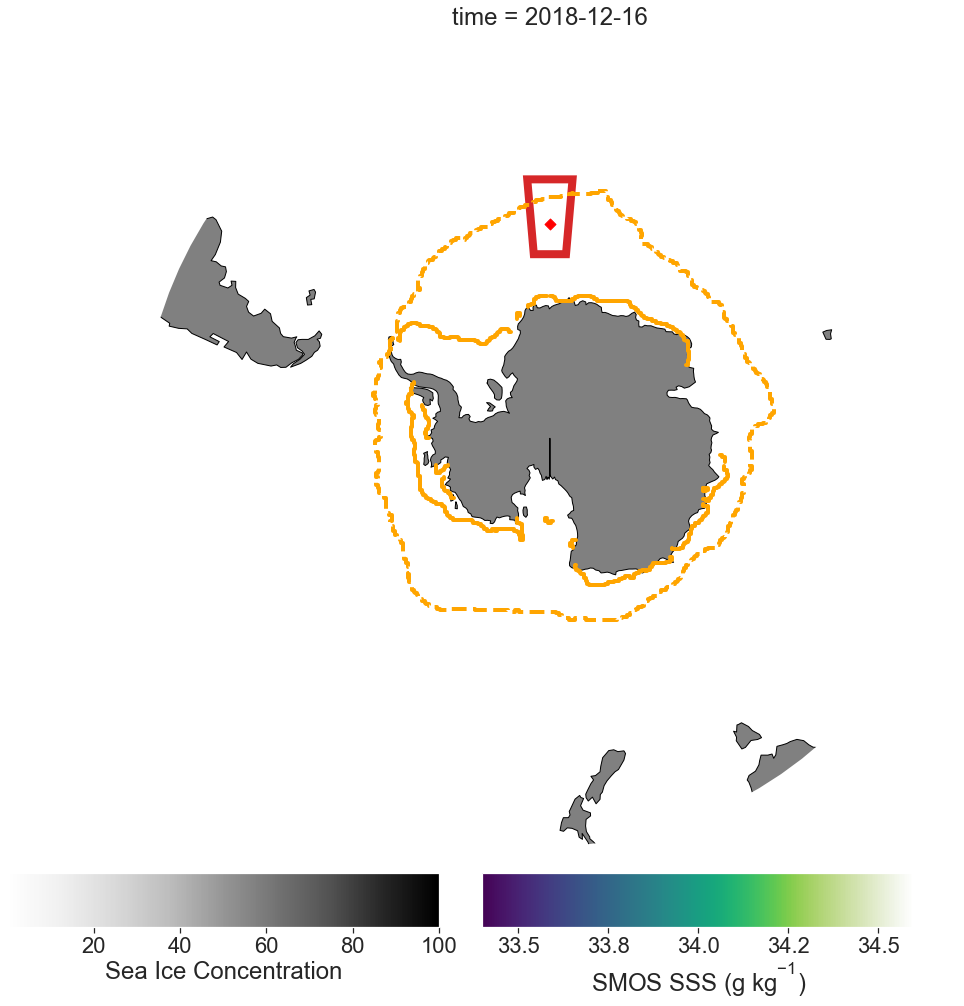

In [18]:
### SMOS Figure

from obspy.imaging.cm import viridis_white
import seaborn as sns
import cartopy
import cartopy.crs as ccrs

import matplotlib
import matplotlib.patches as mpatches
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapefile   
from mpl_toolkits.axes_grid1.inset_locator import inset_axes ,InsetPosition,mark_inset

import matplotlib.path as mpath
import cmocean.cm as cmo

sns.set(font_scale=2)

# Load sea ice extent poplygons

fname1 = r'data/seaice/seaice_extent/extent_S_201809_polyline_v3.0.'
fname2 = r'data/seaice/seaice_extent/extent_S_201902_polyline_v3.0.'

projection =ccrs.SouthPolarStereo(central_longitude=0) # set projection

fig, ax = plt.subplots(1, figsize=(15,15),
                       subplot_kw={'projection': projection})

# SMOS SSS data
cs=smos.sel(time='2018-12-16',lat=slice(-83.517136,-40.131504)).SSS.plot.pcolormesh(ax=ax,
                                                                                    transform=ccrs.PlateCarree(),
                                                                                    vmin=33.4,
                                                                                    vmax=34.6,
                                                                                    cmap=viridis_white,
                                                                                    add_colorbar=False)
cax = fig.add_axes([0.45, 0.05, 0.4, 0.05])
cbar=plt.colorbar(cs,cax=cax,orientation='horizontal',format='%.1f',shrink=0.5)
cbar.set_label('SMOS SSS (g kg$^{-1}$)')


#Ice
cf=ax.pcolormesh(X,Y,sic_new[348,:,:], transform=ccrs.PlateCarree(),cmap='Greys')
cax = fig.add_axes([0.01, 0.05, 0.4, 0.05])
cbar2=plt.colorbar(cf,cax=cax,orientation='horizontal',format='%.0f',shrink=0.5)
cbar2.set_label('Sea Ice Concentration')

#Sea Ice extent 
# Max Extent 2018
sf = shapefile.Reader(fname1)
for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        listx = [i[0] for i in shape.shape.points[i_start:i_end]]
        listy = [i[1] for i in shape.shape.points[i_start:i_end]]
        ax.plot(listx,listy,transform=ccrs.SouthPolarStereo(),c='orange', 
                linestyle='--',linewidth=4,label='Max Sea Ice Extent')

# Min Extent 2019
sf = shapefile.Reader(fname2)
for shape in sf.shapeRecords():
    for i in range(len(shape.shape.parts)):
        i_start = shape.shape.parts[i]
        if i==len(shape.shape.parts)-1:
            i_end = len(shape.shape.points)
        else:
            i_end = shape.shape.parts[i+1]
        listx = [i[0] for i in shape.shape.points[i_start:i_end]]
        listy = [i[1] for i in shape.shape.points[i_start:i_end]]
        ax.plot(listx,listy,transform=ccrs.SouthPolarStereo(),c='orange',
                linestyle='-',linewidth=4,label='Min Sea Ice Extent')


# Study site
ax.add_patch(mpatches.Rectangle(xy=[-5, -64], width=10, height=10,
                                    facecolor='None',edgecolor='tab:red',linewidth=8,
                                    alpha=1,
                                    transform=ccrs.PlateCarree()))

ax.scatter(0,-60,c='red',s=60,marker='D', transform=ccrs.PlateCarree())


# Some edits to the plot
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black', facecolor='Grey')

theta = np.linspace(0, 2*np.pi, 100)   # Make plot a circle
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

ax.set_boundary(circle, transform=ax.transAxes)
ax.outline_patch.set_visible(False)

plt.savefig('results/map2018_smos_v6.png',bbox_inches='tight',transparent=True,dpi=100)

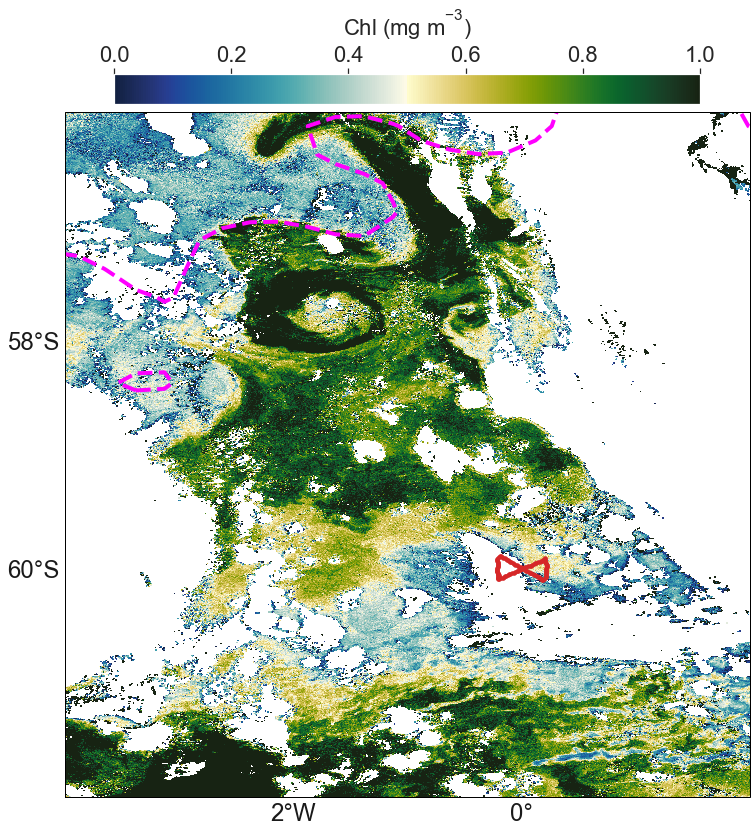

In [19]:
## Figure 1b - Chl
### Chlorophyll

import matplotlib
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica'],'size':22})
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)


projection =ccrs.PlateCarree()#
data_crs=ccrs.PlateCarree()

fig, ax = plt.subplots(1, 1, figsize=(15,15),
                       subplot_kw={'projection': projection})

ax.set_extent([-4, 2, -62, -56])

# Chl data
chlnorm=chl.CHL_OC4ME
z = np.ma.masked_where(chlnorm <= 0, chlnorm)
cs=ax.pcolormesh(chl.longitude,chl.latitude,z,vmin=0, vmax=1,cmap=cmo.delta,transform=data_crs)

cax,kw = matplotlib.colorbar.make_axes(ax,location='top',pad=0.01,shrink=0.7)
out=fig.colorbar(cs,cax=cax,**kw)
label=out.set_label('Chl (mg m$^{-3}$)',size=22,verticalalignment='bottom')

# Seaglider location
ax.scatter(lon[522:644],lat[522:644],facecolor='tab:red',s=12,transform=data_crs)

# Location of the Southern Boundary of the ACC
ax.contour(adt.longitude,adt.latitude,adt.adt[38,:,:], levels=[-1.244],colors='magenta',
           linestyles='--',transform=data_crs,linewidths=4)

# Plot cleaning
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-4, -2, 0, 2,4])
gl.ylocator = mticker.FixedLocator([-62, -60, -58, -56,-54])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 24, 'color': 'k'}
gl.ylabel_style = {'size': 24, 'color': 'k'}

plt.savefig('results/chl_summer_2018_v3.png',dpi=75,bbox_inches='tight')


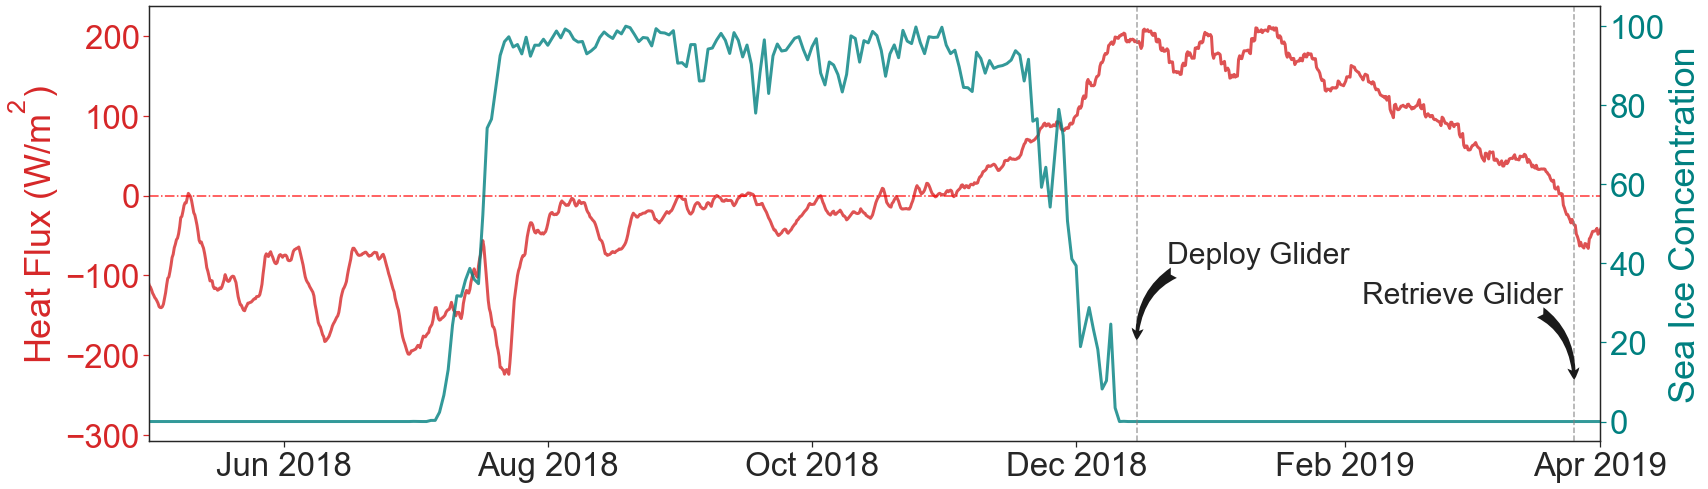

In [17]:
# Seasonality

import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=[26,8],sharex=True)
sns.set(font_scale=3)


sns.set_style('white')
sns.set(font_scale=3)
sns.set_style("ticks", {"xtick.major.size": 20, "ytick.major.size": 20})


#heat flux
ax.plot(era5_annual.time,pd.Series(Qnet),c='tab:red',linewidth=3,alpha=0.8)
ax.set_ylabel('Heat Flux (W/m$^2$)',c='tab:red')
ax.tick_params(axis='y', colors='tab:red')
ax.axhline(0,c='red',alpha=0.8,linestyle='dashdot')

#seaice
ax3=ax.twinx()
ax3.plot(sic_date,np.nanmean(np.nanmean(seaice[:,ind[0],ind[1]],axis=1),axis=1),c='teal',linewidth=3,alpha=0.8)
ax3.set_ylabel('Sea Ice Concentration',c='teal')

ax3.tick_params(axis='y', colors='teal')

ax3.set_xlim(np.array(avisoAn.time[30]),np.array(avisoAn.time[-1]))


ax3.axvline(np.array(avisoAn.time[258]),c='Grey',linestyle='--',alpha=0.7) # Start deployment
ax3.axvline(np.array(avisoAn.time[359]),c='Grey',linestyle='--',alpha=0.7) # End deployment


# Mark start and end of deployment
ax3.annotate('Deploy Glider', xy=(np.array(avisoAn.time[258]),20),  xycoords='data',
            xytext=(np.array(avisoAn.time[265]),40),fontsize=30,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax3.annotate('Retrieve Glider', xy=(np.array(avisoAn.time[359]),10),  xycoords='data',
            xytext=(np.array(avisoAn.time[310]),30),fontsize=30,
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

# Plot formatting
months = mdates.MonthLocator(interval=2, tz=None)
ax.xaxis.set_major_locator(months)
h_fmt= mdates.DateFormatter('%b %Y')
ax.xaxis.set_major_formatter(h_fmt)

plt.savefig('results/sg643_fig1_seasonality.pdf',dpi=75,bbox_inches='tight')


In [21]:
np.nanmean(np.sqrt(adt.vgos[10,20,:50]**2+adt.ugos[10,20,:50]**2))

0.077551747985266747

## Vertical and Horizontal Buoyancy

In [22]:
## Put this somewhere

# Distance of glider sample site from Southern Boundary
import gsw as gsw
gsw.distance([0,0],[-60,-56])/1000

array([ 444.77970658])

In [23]:
lat_point=-60
f = sms_fluxes.coriolis_acc(np.nanmean(lat_point)) # Coriolis Acceleration

alpha,beta= sms_fluxes.alphabeta(SA,CT,depth) #Thermal Expansion Coeffient and Saline Contraction Coefficient

mld = pd.Series(sms_fluxes.calc_mld(np.array(rho),np.array(depth),ref_depth=10))  #Mixed Layer Depth

Buoyancy (kindof the inverse of density) is defined as

$$
b _x = g(1-\rho/\rho_0)
$$



In [24]:
by=(9.8*(1-(rho[:]/1027)))

Buoyancy including salinity and temperature contributions
$$
b_x=g\alpha \frac {\delta T} {\delta x} - g\beta \frac {\delta S} {\delta x}
$$

In [25]:

g=9.8
by=(9.8*(1-(rho[:]/1027)))
b=g*alpha[:,:-1]*np.diff(CT,axis=1)-g*beta[:,:-1]*np.diff(SA,axis=1)
bT=g*alpha[:,:-1]*CT.diff(dim='distance')   # Temperature contribution
bS=g*beta[:,:-1]*SA.diff(dim='distance')    # Salinity contribution
bgrad=np.diff(by)/1000

# average lateral buoyancy gradient in the mixed layer (at least 15m above the ML)
bxml=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    bxml[i]=(np.nanmean(bgrad[:np.int8(mld[i])-15,i],0))
    
bxml=pd.Series(bxml).interpolate()

# point lateral buoyancy gradient in the middle of the ML
bxmd=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    bxmd[i]=bgrad[np.int8(mld[i]/2),i]
    
bxmd=pd.Series(bxmd).interpolate()

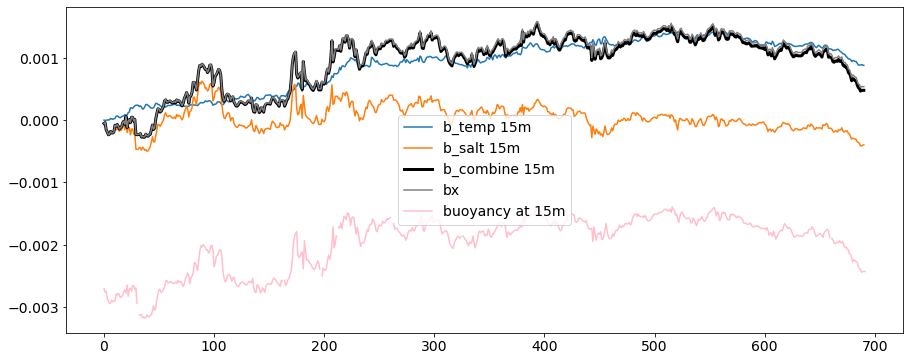

In [84]:
# Checking the decomposition algorithm

plt.figure(figsize=[15,6])
plt.plot(np.nancumsum(bT[15,:]),label='b_temp 15m')
plt.plot(np.nancumsum(-bS[15,:]),label='b_salt 15m')
plt.plot(np.nancumsum(bT[15,:])-(np.nancumsum(bS[15,:])),c='k',linewidth=3,label='b_combine 15m')
plt.plot(np.nancumsum(bgrad[15,:]*1000),c='Grey',label='bx')

plt.plot((by[15,:]),c='pink',label='buoyancy at 15m')
plt.legend()




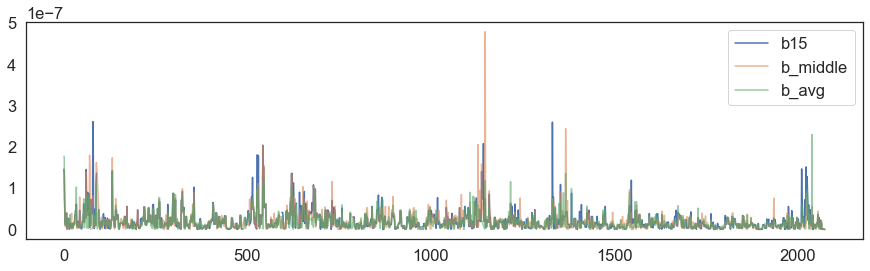

In [105]:
# Difference between ML buoyancy gradient choices

plt.figure(figsize=[15,4])
plt.plot(np.abs(bgrad[15,:]),label='b15')
plt.plot(np.abs(bxmd[:]),alpha=0.6,label='b_middle')
plt.plot(np.abs(bxml),alpha=0.6,label='b_avg')
plt.legend()
#plt.savefig('figures/bx_comparison.png',bbox_inches='tight',dpi=75)


Vertical stratification is defined by the Brunt Vaisala frequency

$$
N^2 = \delta b / \delta z 
$$

It can be separated into temperature and salinity components

$$
N^2_T = g\alpha \frac {\delta T} {\delta z} 
$$

$$
N^2_S = N^2 - N^2_T
$$

In [26]:
# Vertical Stratification

import gsw
import pandas as pd
_,y=np.meshgrid(dist,depth)

n2 = np.diff(by,axis=0)*-1
n2_t=(g*alpha[:-1,:]*np.diff(CT,axis=0))*-1   # Temperature component
n2_S=(g*beta[:-1,:]*np.diff(SA,axis=0)*-1)   # Temperature component



n2_s = n2-n2_t # Salt component

# ML N2
# Total
n2ml=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    n2ml[i]=(np.nanmean(n2[(np.int8(mld[i])-5):np.int8(mld[i])+5,i],0))
    
n2ml=pd.Series(n2ml).interpolate()

# Temperature component
n2mlT=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    n2mlT[i]=(np.nanmean(n2_t[np.int8(mld[i])-5:np.int8(mld[i])+5,i],0))
    
n2mlT=pd.Series(n2mlT).interpolate()

# Salinity component
n2mlS=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    n2mlS[i]=(np.nanmean(n2_s[np.int8(mld[i])-5:np.int8(mld[i])+5,i],0))
    
n2mlS=pd.Series(n2mlS).interpolate()


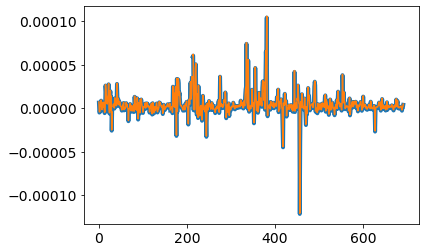

In [88]:
plt.plot(n2[15,:],lw=4)
plt.plot(n2_t[15,:]-n2_S[15,:])

In [325]:
# mld
np.sum(np.where((mld>15)&(mld<75),1,0))

2042

In [327]:
2042/2075

0.9840963855421687

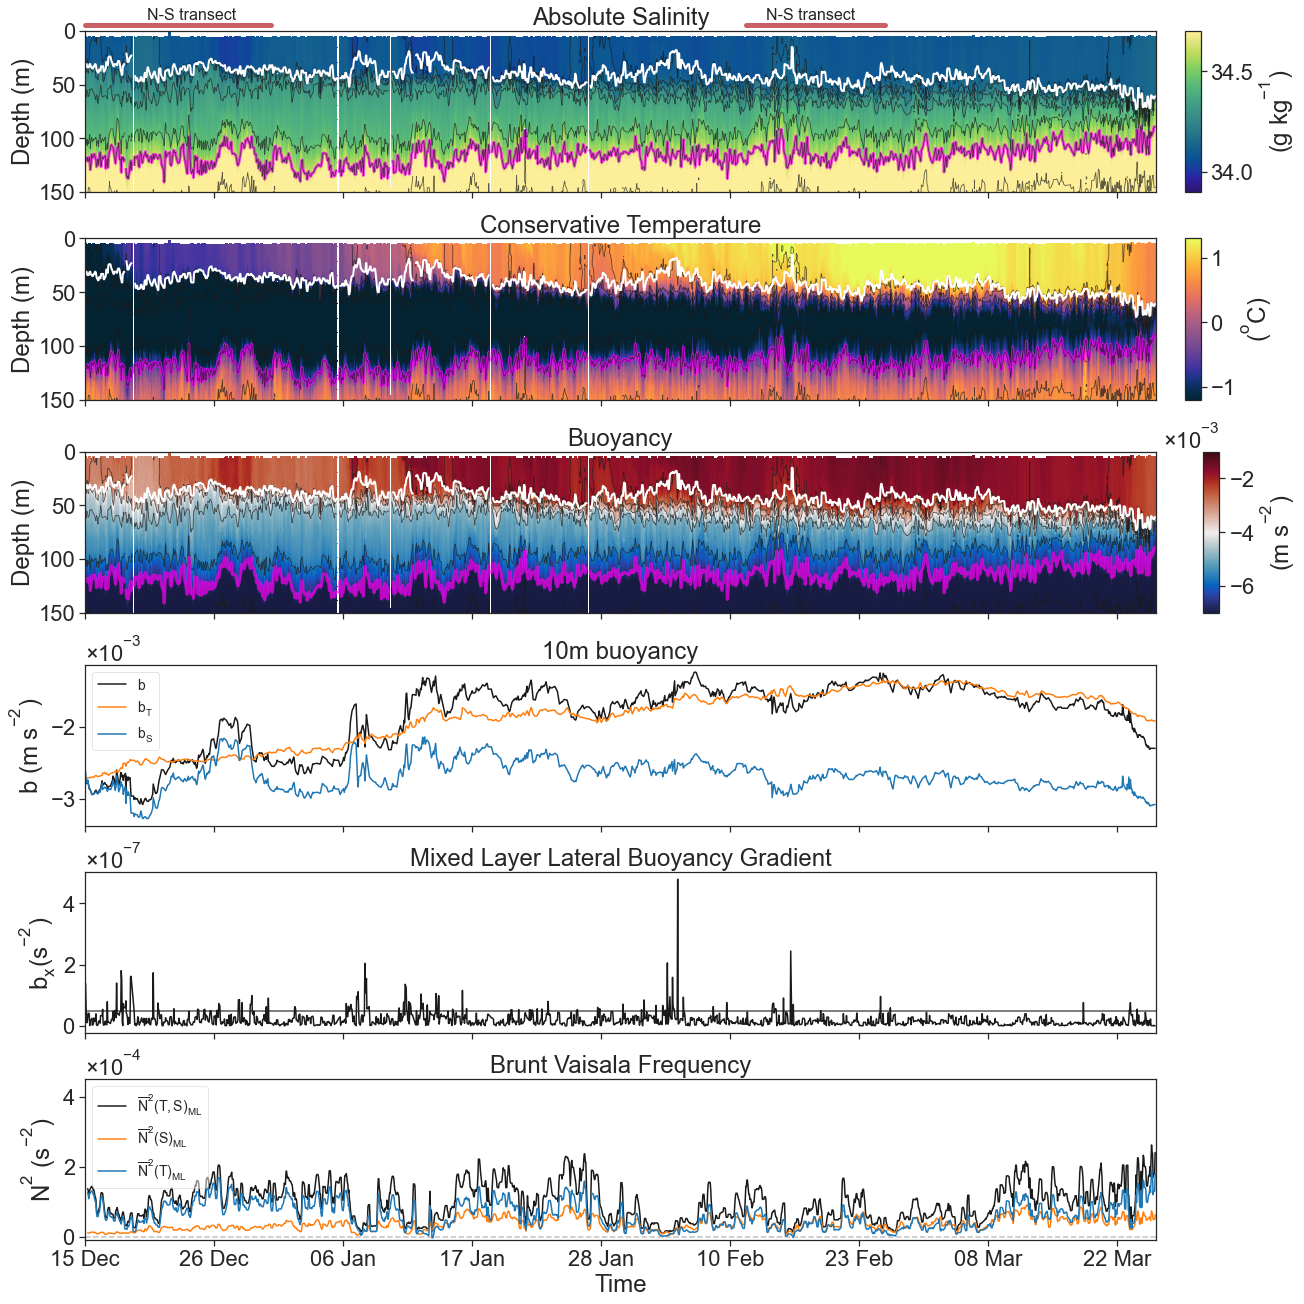

In [422]:
import seaborn as sns
sns.set(font_scale=2)
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

from matplotlib import pyplot, lines
from matplotlib import ticker
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 

fig,ax=plt.subplots(6,1,figsize=[18,18],sharex=True,constrained_layout=True)

ax[0].set_title('Absolute Salinity')
x,y=np.meshgrid(dist,depth)
cs=ax[0].pcolormesh(x,y,SA,cmap=cmo.haline,vmin=33.9,vmax=34.7)
ax[0].contour(x,y, rho,levels=[1027.7],colors='magenta',linewidths=3,alpha=0.7)


cbar=plt.colorbar(cs,ax=ax[0],aspect=10)
cbar.set_label('(g kg$^{-1}$)')
levels=np.arange(1027,1028,0.1)
ax[0].contour(x,y, rho,levels=levels,colors='k',linewidths=0.8,alpha=0.7)
ax[0].plot(dist[:],pd.Series(mld).rolling(3).median(),c='w',linewidth=2)

ax[0].set_ylim(150,0)
ax[0].set_ylabel('Depth (m)')

######

ax[1].set_title('Conservative Temperature')
x,y=np.meshgrid(dist,depth)
cs=ax[1].pcolormesh(x,y,CT,cmap=cmo.thermal,vmin=-1.2,vmax=1.3)
ax[1].contour(x,y, rho,levels=[1027.7],colors='magenta',linewidths=3,alpha=0.7)


cbar=plt.colorbar(cs,ax=ax[1],aspect=10)
cbar.set_label('($^{o}$C)')
levels=np.arange(1027,1028,0.1)
ax[1].contour(x,y, rho,levels=levels,colors='k',linewidths=0.8,alpha=0.7)
ax[1].plot(dist[:],pd.Series(mld).rolling(3).median(),c='w',linewidth=2)

ax[1].set_ylim(150,0)
ax[1].set_ylabel('Depth (m)')

######

ax[2].set_title('Buoyancy')
x,y=np.meshgrid(dist,depth)
cs=ax[2].pcolormesh(x,y,by,cmap=cmo.balance,vmin=-0.007,vmax=-0.001)
cbar=plt.colorbar(cs,ax=ax[2],aspect=10,pad=0.001)
cbar.formatter.set_powerlimits((0, 0))
cbar.formatter._useMathText = True


cbar.update_ticks()
cbar.set_label('(m s$^{-2})$')
levels=np.arange(1027,1028,0.1)
ax[2].contour(x,y, rho,levels=levels,colors='k',linewidths=0.8,alpha=0.7)
ax[2].plot(dist[:],pd.Series(mld).rolling(3).median(),c='w',linewidth=2)
ax[2].contour(x,y, rho,levels=[1027.7],colors='magenta',linewidths=3,alpha=0.7)

ax[2].set_ylabel('Depth (m)')


ax[2].set_ylim(150,0)

#####

ax[3].set_title('10m buoyancy')

ax[3].plot(dist[:-1],(np.array(by[15,0])+np.nancumsum(bT[15,:])-(np.nancumsum(bS[15,:]))),
           c='k',label=u'$b$')#'\\\rho_0$')
ax[3].plot(dist[:-1],(np.array(by[15,0])+np.nancumsum(bT[15,:])),c='tab:orange',label=u'$b_T$')
ax[3].plot(dist[:-1],(np.array(by[15,0])+np.nancumsum(-bS[15,:])),c='tab:blue',label=u'$b_S$')

ax[3].legend(loc='best',framealpha=0.5,fontsize=14)
formatter = ticker.ScalarFormatter(useMathText=True)

ax[3].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax[3].yaxis.major.formatter._useMathText = True

ax[3].set_ylabel('b (m $s^{-2})$')


####
ax[4].set_title('Mixed Layer Lateral Buoyancy Gradient')
ax[4].axhline(0.5e-7, c='Gray',linewidth=2)
ax[4].plot(dist[:-1],np.abs(bxmd),c='k')

ax[4].set_ylabel('$b_x (s^{-2})$')
ax[4].ticklabel_format(axis='y', style='sci', scilimits=(-7,-7))
ax[4].yaxis.major.formatter._useMathText = True

####

ax[5].set_title('Brunt Vaisala Frequency')
ax[5].plot(dist[:-1],pd.Series(n2ml).rolling(6).median(),c='k',label='$\overline{N}{^2}(T,S)_{ML}$')
ax[5].plot(dist[:-1],pd.Series(n2mlT).rolling(6).median(),c='tab:orange',label='$\overline{N}{^2}(S)_{ML}$')
ax[5].plot(dist[:-1],pd.Series(n2mlS).rolling(6).median(),c='tab:blue',label='$\overline{N}{^2}(T)_{ML}$')

ax[5].axhline(0,c='Grey',alpha=0.5,linestyle='--')
ax[5].legend(loc='upper left',framealpha=0.5,fontsize=14)
ax[5].set_ylim(-1e-5,4.5e-4)
ax[5].set_ylabel('$N^2$ $(s^{-2})$')
ax[5].set_xticks([0,250000, 500000,750000, 1000000,1250000,1500000,1750000,2000000])  # this is a bit of a hack 
ax[5].set_xticklabels(['15 Dec','26 Dec','06 Jan','17 Jan','28 Jan',
                       '10 Feb','23 Feb','08 Mar','22 Mar'])

ax[5].set_xlabel('Time')

ax[5].ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
ax[5].yaxis.major.formatter._useMathText = True
ax[5].set_xlim(dist[0],dist[-1])


# Add lines to show mesoscale transects
x,y = np.array([[0, dist[360]], [-5, -5]])
line = lines.Line2D(x, y, lw=5., color='r', alpha=0.9)
ax[0].add_line(line)
line.set_clip_on(False)

x,y = np.array([[dist[1280], dist[1550]], [-5, -5]])
line = lines.Line2D(x, y, lw=5., color='r', alpha=0.9)
ax[0].add_line(line)
line.set_clip_on(False)

ax[0].text(dist[120],-10,'N-S transect',fontsize=16)
ax[0].text(dist[1320],-10,'N-S transect',fontsize=16)

plt.savefig('results/buoyancy_summer_2018.pdf',dpi=75,bbox_inches='tight')



## Turner Angle Analysis

The verticle Turner angle ([Turner et al. 1973](https://doi.org/10.1017/CBO978051160882)) defined as:

$$
Tu = \arctan(R_p)
$$

where 
$$
Rp = \alpha \frac {\delta T} {\delta z} (\beta \frac {\delta S} {\delta z})^{-1}
$$


Similarly, the horizontal turner angle is defined by replacing the vertical gradient with the horizontal:

$$
Rp_{horizontal} = \alpha \frac {\delta T} {\delta x} (\beta \frac {\delta S} {\delta x})^{-1}
$$







In [45]:
# vertical
Rpx=(alpha[:-1,:]*(np.diff(CT,axis=0))/(beta[:-1,:]*(np.diff(SA,axis=0))))
Tux=(np.arctan(Rpx))

# Lateral
RpxL=(alpha[:,:-1]*(np.diff(CT,axis=1)/3000)/(beta[:,:-1]*(np.diff(SA,axis=1)/3000)))
TuxL=pd.Series((np.arctan(RpxL[15,:]))).interpolate()

In [46]:
TuxL.shape

(2074,)

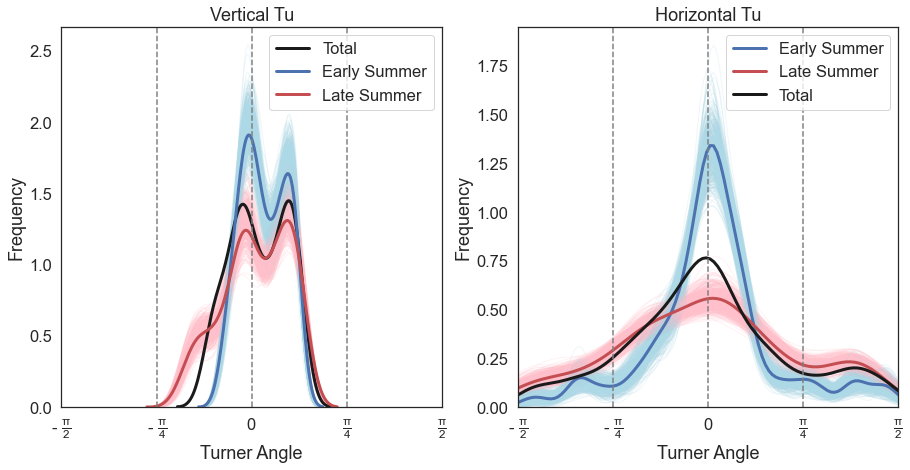

In [47]:
import seaborn as sns
sns.set(font_scale=1.5)

sns.set_style('white')
sns.set_color_codes()


bins = np.linspace(-np.pi/2,np.pi/2, 20)

fig,ax=plt.subplots(1,2,figsize=[15,7])
ax[0].set_title('Vertical Tu')


summer_subset=pd.Series(np.nanmean(Tux[10:200,10:490],axis=1)).interpolate()
sample = np.random.choice(summer_subset, size=300) 


lsummer_subset=pd.Series(np.nanmean(Tux[10:200,1467:1857],axis=1)).interpolate()
sample2 = np.random.choice(lsummer_subset, size=300) 


# Added confidence interval using bootstrapping
for _ in range(500):  #so B=10000
    sample_n = np.random.choice(summer_subset, size=300)
    sample_n2 = np.random.choice(lsummer_subset, size=300)


    sns.distplot(pd.Series((sample_n)), hist=False, bins=bins,
                 rug=False,kde_kws={"color": "lightblue", "lw": 1,'alpha':0.2},ax=ax[0])
    sns.distplot(pd.Series((sample_n2)), hist=False,bins=bins,
                 rug=False,kde_kws={"color": "pink", "lw": 1,'alpha':0.2},ax=ax[0])

sns.distplot(pd.Series(np.nanmean(Tux[10:200,:],axis=1)).interpolate(), hist=False,bins=bins ,rug=False,label='Total',kde_kws={"color": "k", "lw": 3},ax=ax[0])

sns.distplot(pd.Series(np.nanmean(Tux[10:200,10:490],axis=1)).interpolate(), 
             hist=False, bins=bins,rug=False,label='Early Summer',kde_kws={"color": "b", "lw": 3},ax=ax[0])
sns.distplot(pd.Series(np.nanmean(Tux[10:200,1467:1857],axis=1)).interpolate(),
             hist=False,bins=bins, rug=False,label='Late Summer',kde_kws={"color": "r", "lw": 3},ax=ax[0])
ax[0].axvline(x=-np.pi/4,c='Gray',linestyle='--')
ax[0].axvline(x=np.pi/4,c='Gray',linestyle='--')
ax[0].axvline(x=0,c='Gray',linestyle='--')

ax[0].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4,np.pi/2])
ax[0].set_xticklabels([r'- $\frac{\pi}{2}$',r'- $\frac{\pi}{4}$','$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Turner Angle')
ax[0].set_xlim(-np.pi/2,np.pi/2)

ax[1].set_title('Horizontal Tu')

bins = np.linspace(-np.pi/2,np.pi/2,20)


summer_subset=TuxL[10:390]
sample = np.random.choice(summer_subset, size=300) 

lsummer_subset=TuxL[1467:1857]
sample2 = np.random.choice(lsummer_subset, size=300) 


for _ in range(500):  #so B=10000
    sample_n = np.random.choice(summer_subset, size=300)
    sample_n2 = np.random.choice(lsummer_subset, size=300)


    sns.distplot(pd.Series((sample_n)), hist=False, bins=bins,
                 rug=False,kde_kws={"color": "lightblue", "lw": 1,'alpha':0.2},ax=ax[1])
    sns.distplot(pd.Series((sample_n2)), hist=False,bins=bins, 
                 rug=False,kde_kws={"color": "pink", "lw": 1,'alpha':0.2},ax=ax[1])

sns.distplot(pd.Series((summer_subset)), hist=False, bins=bins,
             rug=False,label='Early Summer',kde_kws={"color": "b", "lw": 3},ax=ax[1])
sns.distplot(pd.Series((lsummer_subset)), hist=False,bins=bins, 
             rug=False,label='Late Summer',kde_kws={"color": "r", "lw": 3},ax=ax[1])


sns.distplot(pd.Series((TuxL[:])), hist=False,bins=bins,
             rug=False,label='Total',kde_kws={"color": "k", "lw": 3},ax=ax[1])


ax[1].axvline(x=-np.pi/4,c='Gray',linestyle='--')
ax[1].axvline(x=np.pi/4,c='Gray',linestyle='--')
ax[1].axvline(x=0,c='Gray',linestyle='--')
ax[1].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4,np.pi/2])            
ax[1].set_xticklabels(
           [r'- $\frac{\pi}{2}$',r'- $\frac{\pi}{4}$','$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax[1].set_xlabel('Turner Angle')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(-np.pi/2,np.pi/2)

plt.savefig('results/Tu_summer_2018.pdf',dpi=75,bbox_inches='tight')

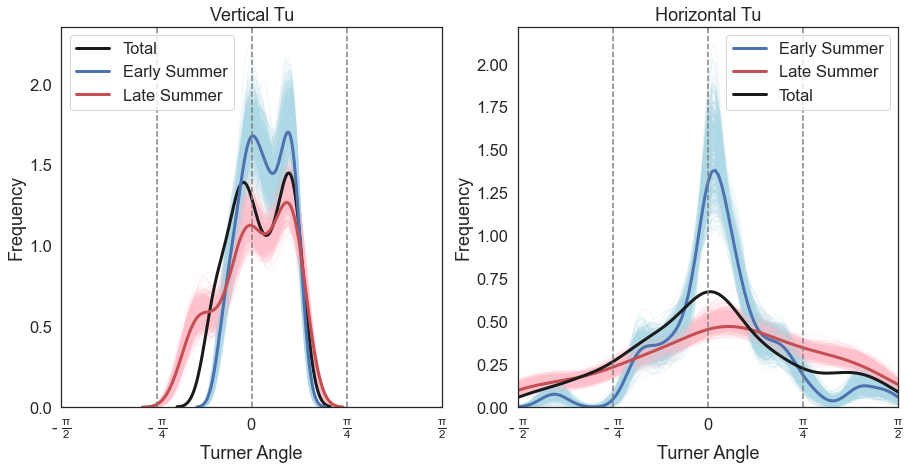

In [93]:
import seaborn as sns
sns.set(font_scale=1.5)

sns.set_style('white')
sns.set_color_codes()


bins = np.linspace(-np.pi/2,np.pi/2, 20)

fig,ax=plt.subplots(1,2,figsize=[15,7])
ax[0].set_title('Vertical Tu')


summer_subset=pd.Series(np.nanmean(Tux[10:200,10:100],axis=1)).interpolate()
sample = np.random.choice(summer_subset, size=300) 


lsummer_subset=pd.Series(np.nanmean(Tux[10:200,500:600],axis=1)).interpolate()
sample2 = np.random.choice(lsummer_subset, size=300) 


# Added confidence interval using bootstrapping
for _ in range(500):  #so B=10000
    sample_n = np.random.choice(summer_subset, size=300)
    sample_n2 = np.random.choice(lsummer_subset, size=300)


    sns.distplot(pd.Series((sample_n)), hist=False, bins=bins,
                 rug=False,kde_kws={"color": "lightblue", "lw": 1,'alpha':0.2},ax=ax[0])
    sns.distplot(pd.Series((sample_n2)), hist=False,bins=bins,
                 rug=False,kde_kws={"color": "pink", "lw": 1,'alpha':0.2},ax=ax[0])

sns.distplot(pd.Series(np.nanmean(Tux[10:200,:],axis=1)).interpolate(), hist=False,bins=bins ,rug=False,label='Total',kde_kws={"color": "k", "lw": 3},ax=ax[0])

sns.distplot(pd.Series(np.nanmean(Tux[10:200,10:100],axis=1)).interpolate(), 
             hist=False, bins=bins,rug=False,label='Early Summer',kde_kws={"color": "b", "lw": 3},ax=ax[0])
sns.distplot(pd.Series(np.nanmean(Tux[10:200,500:600],axis=1)).interpolate(),
             hist=False,bins=bins, rug=False,label='Late Summer',kde_kws={"color": "r", "lw": 3},ax=ax[0])
ax[0].axvline(x=-np.pi/4,c='Gray',linestyle='--')
ax[0].axvline(x=np.pi/4,c='Gray',linestyle='--')
ax[0].axvline(x=0,c='Gray',linestyle='--')

ax[0].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4,np.pi/2])
ax[0].set_xticklabels([r'- $\frac{\pi}{2}$',r'- $\frac{\pi}{4}$','$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax[0].set_ylabel('Frequency')
ax[0].set_xlabel('Turner Angle')
ax[0].set_xlim(-np.pi/2,np.pi/2)

ax[1].set_title('Horizontal Tu')

bins = np.linspace(-np.pi/2,np.pi/2,20)


summer_subset=TuxL[10:100]
sample = np.random.choice(summer_subset, size=300) 

lsummer_subset=TuxL[500:600]
sample2 = np.random.choice(lsummer_subset, size=300) 


for _ in range(500):  #so B=10000
    sample_n = np.random.choice(summer_subset, size=300)
    sample_n2 = np.random.choice(lsummer_subset, size=300)


    sns.distplot(pd.Series((sample_n)), hist=False, bins=bins,
                 rug=False,kde_kws={"color": "lightblue", "lw": 1,'alpha':0.2},ax=ax[1])
    sns.distplot(pd.Series((sample_n2)), hist=False,bins=bins, 
                 rug=False,kde_kws={"color": "pink", "lw": 1,'alpha':0.2},ax=ax[1])

sns.distplot(pd.Series((summer_subset)), hist=False, bins=bins,
             rug=False,label='Early Summer',kde_kws={"color": "b", "lw": 3},ax=ax[1])
sns.distplot(pd.Series((lsummer_subset)), hist=False,bins=bins, 
             rug=False,label='Late Summer',kde_kws={"color": "r", "lw": 3},ax=ax[1])


sns.distplot(pd.Series((TuxL[:])), hist=False,bins=bins,
             rug=False,label='Total',kde_kws={"color": "k", "lw": 3},ax=ax[1])


ax[1].axvline(x=-np.pi/4,c='Gray',linestyle='--')
ax[1].axvline(x=np.pi/4,c='Gray',linestyle='--')
ax[1].axvline(x=0,c='Gray',linestyle='--')
ax[1].set_xticks([-np.pi/2, -np.pi/4, 0, np.pi/4,np.pi/2])            
ax[1].set_xticklabels(
           [r'- $\frac{\pi}{2}$',r'- $\frac{\pi}{4}$','$0$', r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$'])
ax[1].set_xlabel('Turner Angle')
ax[1].set_ylabel('Frequency')
ax[1].set_xlim(-np.pi/2,np.pi/2)

plt.savefig('results/Tu_summer_2018_3km.pdf',transparent=True,dpi=75,bbox_inches='tight')

In [25]:
#Ekman Depth
np.sqrt(2*0.1/-f)

39.79888636383489

## ABI Growth Rate Analysis


Richardson number - gives idea of isopycnal slope steepness

$$
Ri = \frac {N^2} {(\delta u / \delta z)^2} \equiv \frac {f^2 N^2} {b_x^2}
$$

The fastest lengthscale and  growth rate following [Stone 1970](10.1175/1520-0469(1970)027<0721:ONGBSP>2.0.CO;2); [Fox-Kemper et al. 2008](https://doi.org/10.1175/2007JPO3792.1), is defined as:

$$
l_{max} = \frac {2 \pi U} {f} \sqrt {\frac {1+Ri} {5/2}}$$  where 

$$
U \equiv \frac {|b_x|} f H
$$


$$
\tau_{max} = \sqrt {\frac {54} 5} \frac {\sqrt  {1+Ri}} {f}
$$


In [27]:
# Richardson number
Ri = (1.26e-4**2*np.abs(n2[:,:-1]))/np.abs(bgrad[:-1,:])**2

#Ri in the ML
riml=np.ndarray(len(rho[1,:-1]))
for i in range(len(rho[1,:-1])):
    riml[i]=(np.nanmean(Ri[:np.int8(mld[i]),i],0))
riml[1705:1780]=np.nan
riml[-10:]=np.nan
riml[650:700]=np.nan
riml[1250:1500]=np.nan

logRi=np.log(np.abs(riml))
Ri_adj=logRi[logRi!=np.inf] #adjusted to exclude nans and infs


In [28]:
Ri_o1 = (1.26e-4**2*n2[15,:-1])/np.abs(bgrad[15,:])**2

In [29]:
count=0   #how many profiles have Ri < 4 
for i in range(2074):
    if Ri_o1[i]<4:
        count += 1
        
print(count/2074)

0.3355834136933462


In [30]:
# Length scale 
L1=(2*np.pi*mld[:-1]*np.abs(bgrad[15,:])/f)/f*np.sqrt((1+np.abs(Ri_o1))/(5/2))
L=(2*np.pi*40*(10e-7)/f)/f*np.sqrt((1+np.abs(1))/(5/2))

# Wavelength with Ri=1
Lfk=(2*np.pi*100*np.abs(2*f**2)/f)/f*np.sqrt((1+np.abs(1))/(5/2))
print('Wavenumber:',Lfk/1000)

# Growth rate
Time= np.sqrt(54/5)*np.sqrt(1+abs(Ri_o1))/np.abs(f)
Time=Time[Time!=np.inf]

# Growth rate with Ri = 1
Time2= np.sqrt(54/5)*np.sqrt(1+1)/np.abs(f)
print('Growthrate:',Time2/3600)

Wavenumber: 1.12397035697
Growthrate: 10.224362037


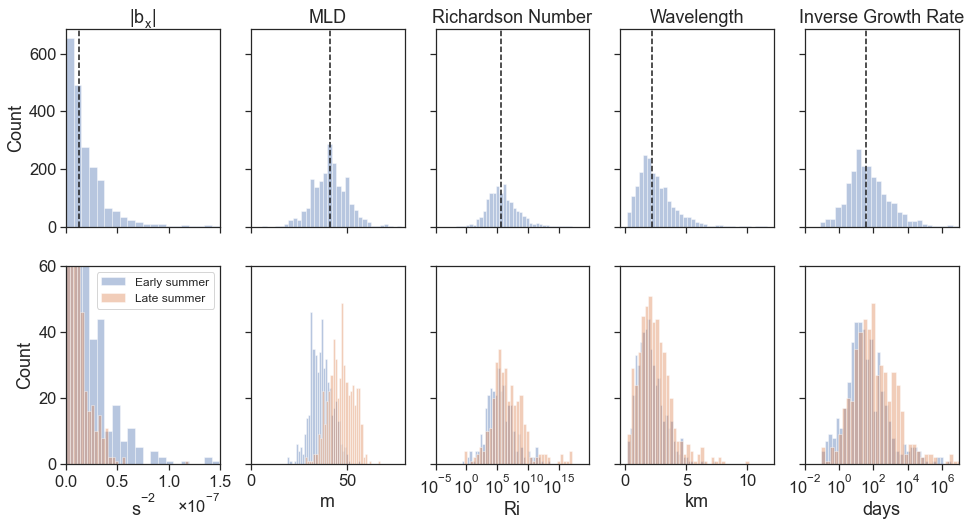

In [428]:
# Alternative Figure 7
import numpy
import seaborn as sns

fig,ax=plt.subplots(2,5,figsize=[16,8],sharex='col',sharey='row')
#plt.subplots_adjust(wspace=0.1)

 # This is buggy
sns.set(font_scale=1.5)
sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

############################



ax[0,0].set_title('|b$_x$|')


sns.distplot(np.abs(bgrad[15,:]),
             hist=True,bins=35,rug=False,label='Total',kde=False,norm_hist=False,ax=ax[0,0])
ax[0,0].axvline(np.nanmedian(np.abs(bgrad[15,:])),c='k',linestyle='--')
ax[0,0].set_xlim(0,1.5e-7)

ax[0,0].set_ylabel('Count')




sns.distplot(np.abs(bgrad[15,:])[10:490],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,0],label='Early summer')
sns.distplot(np.abs(bgrad[15,:])[1450:1950],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,0],label='Late summer')

ax[1,0].set_xlim(0,1.5e-7)
ax[1,0].set_ylim(0,60)



ax[1,0].set_ylabel('Count')


ax[1,0].legend(fontsize=12)

ax[1,0].set_xlabel('s$^{-2}$')

ax[1,0].ticklabel_format(axis='y', style='sci', scilimits=(-3,3))
ax[1,0].xaxis.major.formatter._useMathText = True


############################

ax[0,1].set_title('MLD')

sns.distplot(np.abs(mld), hist=True,bins=35,rug=False,label='Total',kde=False,norm_hist=False,ax=ax[0,1])
ax[0,1].axvline(np.nanmedian(np.abs(mld)),c='k',linestyle='--')
ax[0,1].set_xlim(0,80)


sns.distplot(np.abs(mld[mld!=np.nan][10:490]), 
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,1])
sns.distplot(np.abs(mld[mld!=np.nan][1450:1950]),
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,1])

ax[1,1].set_xlabel('m')


############################

ax[0,2].set_title('Richardson Number')

sns.distplot(np.log(Ri_o1[Ri_o1!=np.inf]),
             hist=True,bins=35,rug=False,label='Total',kde=False,norm_hist=False,ax=ax[0,2])
ax[0,2].axvline(np.nanmedian(np.log(Ri_o1[Ri_o1!=np.inf])),c='k',linestyle='--')
ax[0,2].set_xlim(-5,20)

sns.distplot(np.log(Ri_o1[Ri_o1!=np.inf])[10:490],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,2])
sns.distplot(np.log(Ri_o1[Ri_o1!=np.inf])[1450:1950], 
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,2])

ax[1,2].set_xlim(-5,20)

ax[1,2].set_xticks([-5,0,5,10,15])
                
ax[1,2].set_xticklabels(
           [r'$10^{-5}$',r'$10^{0}$',r'$10^5$','$10^{10}$','$10^{15}$'])

ax[1,2].set_xlabel('Ri')


############################

ax[0,3].set_title('Wavelength')


sns.distplot(L1[L1<500000]/1000,
             hist=True,bins=35,norm_hist=False,rug=False,label='Total',kde=False,ax=ax[0,3])
ax[0,3].axvline(np.nanmedian(L1/1000),c='k',linestyle='--')

sns.distplot((L1[L1<500000]/1000)[10:490],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,3])
sns.distplot((L1[L1<500000]/1000)[1450:1950],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,3])

ax[1,3].set_xlabel('km')

############################

ax[0,4].set_title('Inverse Growth Rate')

sns.distplot(np.log(numpy.ma.masked_invalid(np.abs(Time))/86400),
             hist=True,bins=35,norm_hist=False,rug=False,label='Total',kde=False,ax=ax[0,4])
ax[0,4].axvline(np.nanmedian(np.log(numpy.ma.masked_invalid(np.abs(Time))/86400)),
                c='k',linestyle='--')
ax[0,4].set_xlim(-2,7)

sns.distplot(np.log(numpy.ma.masked_invalid(np.abs(Time))/86400)[10:490],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,4])
sns.distplot(np.log(numpy.ma.masked_invalid(np.abs(Time))/86400)[1450:1950],
             hist=True,bins=35,rug=False,kde=False,norm_hist=False,ax=ax[1,4])

ax[1,4].set_xticks([-2,0,2,4,6])
                
ax[1,4].set_xticklabels(
           [r'$10^{-2}$',r'$10^0$','$10^2$', r'$10^4$', r'$10^6$'])


ax[1,4].set_xlabel('days')

############################


plt.savefig('results/histograms.png',bbox_inches='tight',dpi=75)

In [31]:
# Length scale 
L1=(2*np.pi*mld[:-1]*np.abs(bxml)/f)/f*np.sqrt((1+np.abs(riml))/(5/2))
L=(2*np.pi*40*(10e-7)/f)/f*np.sqrt((1+np.abs(1))/(5/2))

# Wavelength with Ri=1
Lfk=(2*np.pi*100*np.abs(2*f**2)/f)/f*np.sqrt((1+np.abs(1))/(5/2))
print('Wavenumber:',Lfk/1000)

# Growth rate
Time= np.sqrt(54/5)*np.sqrt(1+abs(riml))/np.abs(f)
Time=Time[Time!=np.inf]

# Growth rate with Ri = 1
Time2= np.sqrt(54/5)*np.sqrt(1+1)/np.abs(f)
print('Growthrate:',Time2/3600)


Wavenumber: 1.12397035697
Growthrate: 10.224362037


In [32]:
# Compare to Fox-Kemper et al 2008
#h ~ 100 m
# bx ~ 2f^2
2*(f**2)

3.1886459999999993e-08

## Atmospheric derived surface fluxes

In [33]:
# Q is given in W/m2
Qnet_interp=sms_fluxes.glider_compat(era5_annual.time,time,Qnet) # Interpolated to glider track


To convert freshwater flux from m/s to an equivalent heat flux, first FWF is converted to a buoyancy:

$$
F_b = (E-P)  \times \beta \times g \times S
$$

and then converted to an equivalent heat flux

$$
Q_{FWF} = \frac {F_b \times \rho_0 \times C_p}  {\alpha \times g}
$$


In [35]:
#  FWF computation
fwf_interp=sms_fluxes.glider_compat(erafw.time,time,fwfms) # Interpolated to glider track
F_b=fwf_interp*beta[10,:]*g*pd.Series(SA[15,:]).interpolate()
Qnet_F=(F_b*(1027*4000)/(alpha[10,:]*g))

In [36]:
Qsurf = Qnet_interp+Qnet_F

In [37]:
tau, tau_x, tau_y, wind_dir = sms_fluxes.calc_wind(era5w_subset.u10[:,0],era5w_subset.v10[:,0]) # Wind Stress
tx_interp=pd.Series(sms_fluxes.glider_compat(era5w_subset.time,time,tau_x)).rolling(1).mean() # Interpolated to glider track
ty_interp=pd.Series(sms_fluxes.glider_compat(era5w_subset.time,time,tau_y)).rolling(1).mean()
wind_dir_interp=pd.Series(sms_fluxes.glider_compat(era5w_subset.time,time,wind_dir)).rolling(1).mean()

In [29]:
print('mean wind stress:',np.nanmean(np.sqrt(tx_interp**2+ty_interp**2)))

mean wind stress: 0.09213216467490348


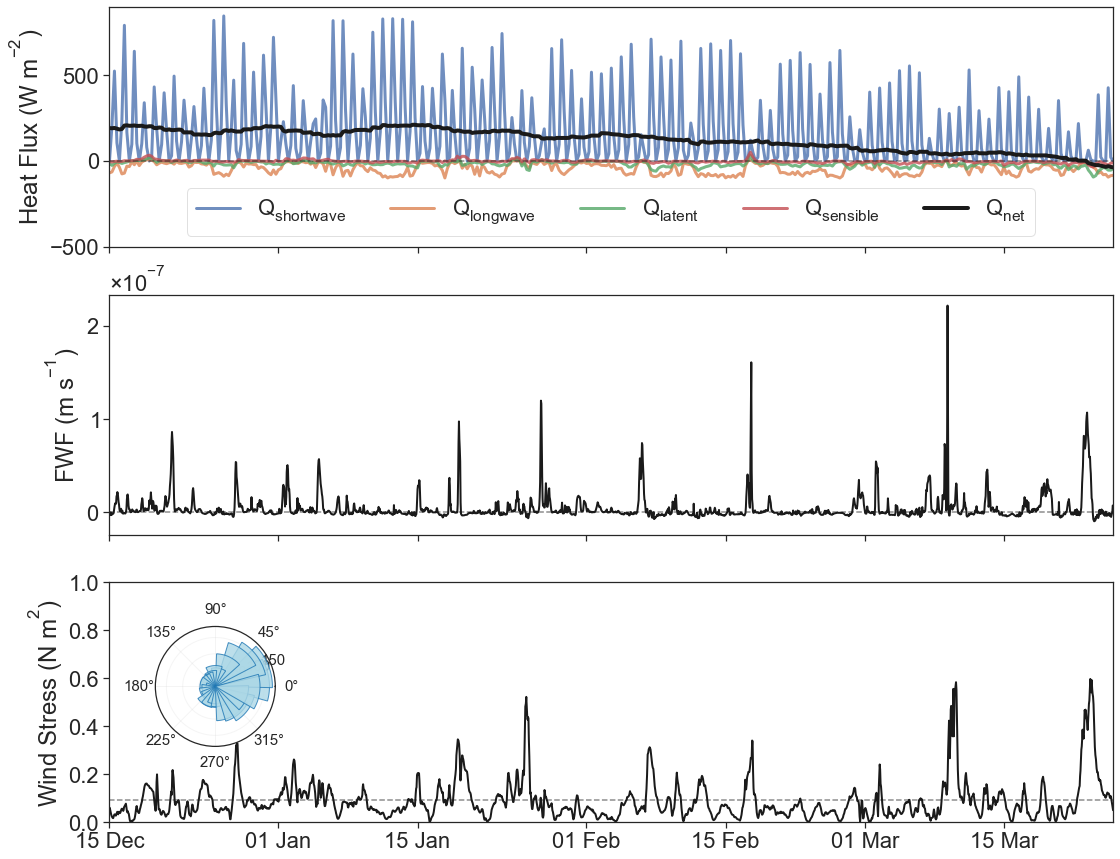

In [30]:
import seaborn as sns
fig,ax=plt.subplots(3,1,figsize=[18,15],sharex=True)
sns.set(font_scale=2)

sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})


import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class


#heat flux
ax[0].plot(era5_annual.time,era5_annual.msnswrf[:,2,4],label='Q$_{shortwave}$',alpha=0.8,linewidth=3)
ax[0].plot(era5_annual.time,era5_annual.msnlwrf[:,2,4],label='Q$_{longwave}$',alpha=0.8,linewidth=3)
ax[0].plot(era5_annual.time,era5_annual.mslhf[:,2,4],label='Q$_{latent}$',alpha=0.8,linewidth=3)
ax[0].plot(era5_annual.time,era5_annual.msshf[:,2,4],label='Q$_{sensible}$',alpha=0.8,linewidth=3)
ax[0].plot(era5_annual.time,pd.Series(Qnet),c='k',linewidth=4,label='Q$_{net}$')
ax[0].legend(loc='lower center',framealpha=0.6,ncol=6)
ax[0].axhline(0,c='k',linestyle='--',alpha=0.5)
ax[0].set_ylim(-500,900)
ax[0].set_ylabel('Heat Flux (W m$^{-2}$)')

# Freshwater Flux
ax[1].plot(erafw.time,(erafw.mer+erafw.mtpr)/3600,c='k',linewidth=2)
ax[1].axhline(0,c='k',linestyle='--',alpha=0.5)
ax[1].ticklabel_format(axis='y',style='sci',scilimits=(-7,7))
ax[1].yaxis.major.formatter._useMathText = True
ax[1].set_ylabel('FWF (m s$^{-1}$)')

# Winds
ax[2].plot(time,np.sqrt(tx_interp**2+ty_interp**2),c='k',linewidth=2)
ax[2].axhline(np.nanmean(np.sqrt(tx_interp**2+ty_interp**2)),c='k',linestyle='--',alpha=0.5)
ax[2].set_ylim(0,1)
ax[2].set_ylabel('Wind Stress (N m$^{2}$)')
ax[2].set_xlim(time.iloc[0],time.iloc[-1])
h_fmt= mdates.DateFormatter('%d %b')
ax[2].xaxis.set_major_formatter(h_fmt)

# Wind direction inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins=inset_axes(ax[2],width="170%", height="50%",
                 axes_class = matplotlib.projections.get_projection_class('polar'),
                 borderpad=2
)

normalise = pd.Series((wind_dir_interp+ 360) % 360).interpolate()   # First normalise winds from -180-180 to 0-360, interpolate over nans

histogram, bins = np.histogram(np.deg2rad(normalise), bins=25)
bin_centers = 0.5*(bins[1:] + bins[:-1])
axins.bar(bin_centers, histogram,label="Wind Orientation",
          color='lightblue',bottom=0.0,alpha=0.8,edgecolor='tab:blue')
axins.grid(alpha=0.2) 
axins.yaxis.get_major_locator().base.set_params(nbins=5)

axins.tick_params(labelsize=15)

plt.savefig('results/sg643_atmospheric_conditions.png',bbox_inches='tight',dpi=75)

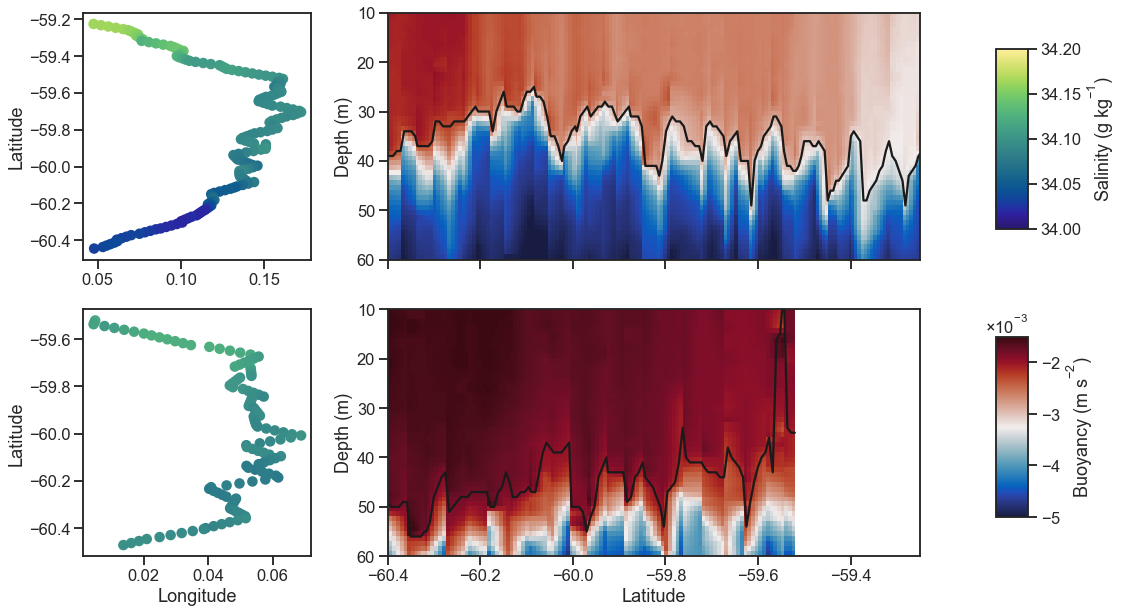

In [437]:
# Mesoscale Ekman Buoyancy Flux

# Overview of mesoscale transects
fig = plt.figure(constrained_layout=False,figsize=[15,10])
gs = gridspec.GridSpec(2, 2, figure=fig,width_ratios=[0.3,0.7])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[1,1])
ax3 = plt.subplot(gs[0,0])
ax4 = plt.subplot(gs[1,0])

cs1=ax3.scatter(lon[120:290],lat[120:290],c=SA[15,120:290],cmap=cmo.haline,vmin=34.0,vmax=34.2)
xx,yy=np.meshgrid(pd.Series(lat[120:290]).interpolate(),pd.Series(depth).interpolate())
ax1.pcolormesh(xx,yy,by[:,120:290],cmap=cmo.balance,vmin=-5e-3,vmax=-1.5e-3)


ax1.set_ylim(60,10)
ax1.set_xlim(-60.4,-59.25)
ax1.plot(lat[120:290],mld[120:290],c='k')

ax4.scatter(lon[1365:1485],lat[1365:1485],c=SA[15,1365:1485],cmap=cmo.haline,vmin=34.0,vmax=34.2)
xx,yy=np.meshgrid(lat[1365:1485],depth)


cs=ax2.pcolormesh(xx,yy,by[:,1365:1485],cmap=cmo.balance,vmin=-5e-3,vmax=-1.5e-3)
ax2.set_ylim(60,10)
ax2.set_xlim(-60.4,-59.25)
ax2.plot(lat[1365:1485],mld[1365:1485],c='k')

cax = fig.add_axes([0.97, 0.58, 0.03, 0.25])
cax2 = fig.add_axes([0.97, 0.18, 0.03, 0.25])

cbar1=plt.colorbar(cs1,cax=cax)
cbar2=plt.colorbar(cs,cax=cax2)

cbar1.set_label('Salinity (g kg$^{-1}$)')
cbar2.set_label('Buoyancy (m s$^{-2}$)')

cbar2.formatter.set_powerlimits((0, 0))
cbar2.formatter._useMathText = True

ax1.set_xticklabels([])

ax3.set_ylabel('Latitude')
ax4.set_ylabel('Latitude')
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Depth (m)')
ax1.set_ylabel('Depth (m)')

ax4.set_xlabel('Longitude')


plt.savefig('results/mesocale_transects.pdf',dpi=75,bbox_inches='tight')

The following computes the salinity component of Ekman Transport converted to an equivalent heat flux (taken from [Pellichero et al., 2017](10.1002/2016JC011970))

$$
dS_{Ekman}/dt = U_e . \nabla S_m 
$$

where, 

$$
U_e =\frac 1 {\rho_o f H} {\tau^y}
$$



In [38]:
f=-1.23e-4

In [39]:
Ue = (1/(1027*f*np.nanmean(mld[:-1][df.trans==1])))*0.09
print(Ue)

-0.0200215276167


Text(0.5, 0, 'lon')

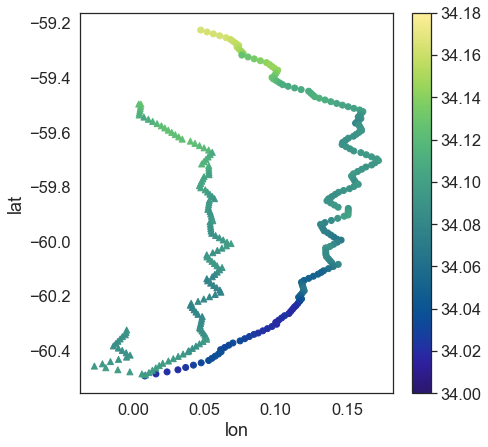

In [1948]:
# Visualize mesoscale transects

plt.figure(figsize=[7,7])
plt.scatter(df.lon[df.trans==1],df.lat[df.trans==1],c=df.SA[df.trans==1],cmap=cmo.haline,vmin=34.0,vmax=34.18)
#plt.scatter(df.lon[df.trans==0],df.lat[df.trans==0],c=df.SA[df.trans==0],marker='v',cmap=cmo.haline,vmin=34.0,vmax=34.18)
plt.scatter(df.lon[df.trans==36],df.lat[df.trans==36],c=df.SA[df.trans==36],marker='^',cmap=cmo.haline,vmin=34.0,vmax=34.18)

plt.colorbar()
plt.ylabel('lat')
plt.xlabel('lon')

In [40]:
distance_grad_M1 = gsw.distance([df.lon[df.trans==1].iloc[-5],df.lon[df.trans==1].iloc[5]],
                                [df.lat[df.trans==1].iloc[-5],df.lat[df.trans==1].iloc[5]])
print('distance M1:',distance_grad_M1)

nablaS = (np.nanmean(df.SA[df.trans==1].iloc[-5:])-np.nanmean(df.SA[df.trans==1].iloc[:5]))/distance_grad_M1

print('dS_ekman/dt M1:',nablaS*Ue) # g/kg/s

distance M1: [ 133618.1337414]
dS_ekman/dt M1: [  8.34193862e-10]


In [41]:
distance_grad_M2 = gsw.distance([df.lon[df.trans==36].iloc[-5],df.lon[df.trans==36].iloc[5]],
                                [df.lat[df.trans==36].iloc[-5],df.lat[df.trans==36].iloc[5]])
print('distance M2:',distance_grad_M2)

nablaS = (np.nanmean(df.SA[df.trans==36].iloc[-5:])-np.nanmean(df.SA[df.trans==36].iloc[:5]))/distance_grad_M2

print('dS_ekman/dt M2:',nablaS*Ue) # g/kg/s


distance M2: [ 92129.78545692]
dS_ekman/dt M2: [ -3.53121684e-09]


In [42]:
# Compared to FWF
Salinity_fwf=(fwf_interp*pd.Series(SA[15,:]).interpolate())/mld
np.nanmean(Salinity_fwf[:400])

print('dS_fwf/dt:',np.nanmean(Salinity_fwf[:400])) # g/kg/s



dS_fwf/dt: 4.86095871608e-09


## Submesoscale Heat Flux Calculations 

Submesoscale Ekman Buoyancy Flux defined by [Thomas and Lee 2005](10.1175/JPO2737.1)

$$
Q_{EBF} = \frac {-b_x \tau _y} {f} \frac {C_p} {\alpha g}
$$

In [43]:

ebf,ty,angle = sms_fluxes.calc_ebf(pd.Series(bxmd).interpolate(),wind_dir_interp[:-1],glider_dir[:],
                          tx_interp[:-1],ty_interp[:-1],f,alpha[10,:-1],cp=4000,g=9.8) 

Submesoscale MLE as in [Fox-Kemper et al 2008](10.1175/2007JPO3792.1)

$$
Q_{MLE} = 0.06 \frac {b_x^2 H^2} {f} \frac  {C_p \rho _0} {\alpha g}
$$

In [44]:
# Use 4km rolling mean to equate the heat flux to the mesoscale field

Qmle = sms_fluxes.calc_qmle(pd.Series(bxmd[:]).rolling(8).mean().interpolate(),pd.Series(mld[:-1]).interpolate(),alpha[10,:-1],f) # Equivalent Heat flux from mixed layer eddies


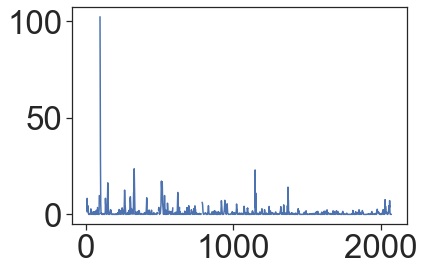

In [45]:
plt.plot(Qmle)

In [46]:
np.nanstd(Qmle)

3.6890599671619864

### example methodology



[]

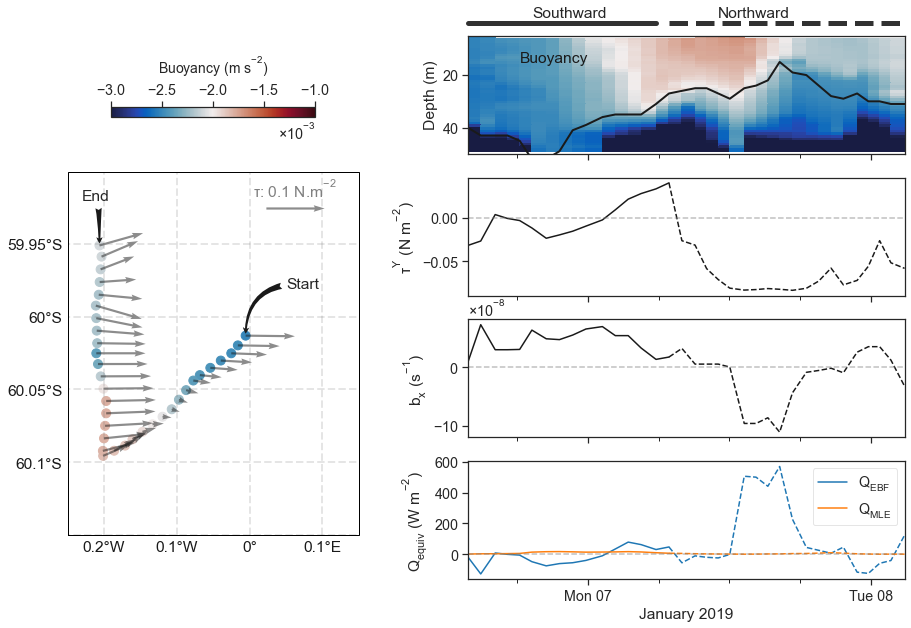

In [46]:
#500: Summer subset
import seaborn as sns
sns.set(font_scale=1.3)
from matplotlib import pyplot, lines

import cartopy
import cartopy.crs as ccrs

import matplotlib
import matplotlib.patches as mpatches
from cartopy.util import add_cyclic_point
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapefile   
from mpl_toolkits.axes_grid1.inset_locator import inset_axes ,InsetPosition,mark_inset

import matplotlib.path as mpath
import cmocean.cm as cmo


sns.set_style('white')
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

fig = plt.figure(constrained_layout=False,figsize=[15,10])
gs = gridspec.GridSpec(4, 2, figure=fig,width_ratios=[0.4,0.6])
plt.subplots_adjust(wspace=0.3)
projection =ccrs.Mercator()#
data_crs=ccrs.PlateCarree()
ax1 = plt.subplot(gs[:,0],projection=projection)
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,1])
ax4 = plt.subplot(gs[2,1])
ax5 = plt.subplot(gs[3,1])

# Select interval
i = 505
j = 540

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
cs=ax1.scatter(lon[i:j],lat[i:j],c=by[15,i:j],s=80,vmin=-3e-3,vmax=-1e-3,cmap=cmo.balance,transform=data_crs) #buoayncy

cax,kw = matplotlib.colorbar.make_axes(ax1,location='top',pad=0.1,shrink=0.7)
out=fig.colorbar(cs,cax=cax,**kw)
label=out.set_label('Buoyancy (m s$^{-2}$)',size=14,verticalalignment='bottom')

out.formatter.set_powerlimits((0, 0))
out.formatter._useMathText = True
out.update_ticks()

Q=ax1.quiver(np.array(lon[i:j]),np.array(lat[i:j]),np.array(tx_interp[i:j]),np.array(ty_interp[i:j]),alpha=0.5,scale=0.5,transform=data_crs)

qk = ax1.quiverkey(Q, 0.78, 0.90, 0.1, r'$\tau$: 0.1 N.m$^{-2}$', labelpos='N',
                 coordinates='axes',labelcolor='Grey',alpha=0.5)  # quiver key

# Clean up map
ax1.set_extent([-0.25, 0.15, -60.15, -59.9])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.2, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlocator = mticker.FixedLocator([-0.3,-0.2, -0.1,0, 0.1,0.2])
gl.ylocator = mticker.FixedLocator([-60.15,-60.1,-60.05, -60, -59.95,-59.9])

gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.xlabel_style = {'color': 'k'}

gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'color': 'k'}

ax1.set_ylabel('Longitude ($^o$E)')
ax1.set_xlabel('Latitude ($^o$N)')


transform = ccrs.PlateCarree()._as_mpl_transform(ax1)

# Add annotations
ax1.annotate('Start', xy=(lon[505],lat[505]),  xycoords=transform,
            xytext=(0.05,-59.98),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

ax1.annotate('End', xy=(lon[539],lat[539]),  xycoords=transform,
            xytext=(-.23,-59.92),
            arrowprops=dict(arrowstyle="fancy",
                            fc="0.1", ec="none",
                            connectionstyle="angle3,angleA=0,angleB=-90"))

################################################

# Buoyancy
by=by.interpolate_na(dim='depth')
x,y=np.meshgrid(np.array(time[505:540]),depth[:50])
cs=ax2.pcolormesh(x,y,by[:50,505:540],vmin=-3e-3,vmax=-1e-3,cmap=cmo.balance)

ax2.plot(time[505:540],mld[505:540],c='k',lw='2')
ax2.set_ylim(50,5)
ax2.set_ylabel('Depth (m)')

# Add annotation to show northward and southward transects

a=pd.to_datetime(np.array(time[505:540]))
x,y = np.array([[(a[0]), (a[14])], [0.24, 0.24]])
line = lines.Line2D(x, y, lw=5., color='k', alpha=0.9)
ax2.add_line(line)
line.set_clip_on(False)

x,y = np.array([[(a[15]), (a[34])], [0.24, 0.24]])
line = lines.Line2D(x, y, lw=5., linestyle='--',color='k', alpha=0.9)
ax2.add_line(line)
line.set_clip_on(False)

ax2.text(a[5],-2,'Southward')
ax2.text(a[19],-2,'Northward')

ax2.text(a[4],15,'Buoyancy',color='k')

################################################
# Rotated winds

ax3.plot(time[505:521],ty[505:521],c='k')
ax3.plot(time[520:540],ty[520:540],c='k',linestyle='--',)
ax3.axhline(0,c='Grey',alpha=0.5,linestyle='--')
ax3.set_ylabel(r'$\tau^Y$ (N m$^{-2}$)')

################################################
# Lateral Buoyancy Gradient
ax4.plot(time[505:521],bxmd[505:521],c='k',linestyle='-')
ax4.plot(time[520:540],bxmd[520:540],c='k',linestyle='--')

ax4.ticklabel_format(axis='y',style='sci',scilimits=(-8,8))
ax4.yaxis.major.formatter._useMathText = True

ax4.ticklabel_format(axis='y', style='sci', scilimits=(-8,-8))
ax4.yaxis.major.formatter._useMathText = True

ax4.axhline(0,c='Grey',alpha=0.5,linestyle='--')
ax4.set_ylabel('b$_x$ (s$^{-1}$)')

################################################
# SMS fluxes

ax5.plot(time[505:521],ebf[505:521],c='tab:blue',linestyle='-',label='$Q_{EBF}$')
ax5.plot(time[520:540],ebf[520:540],c='tab:blue',linestyle='--')

ax5.plot(time[505:521],Qmle[505:521],c='tab:orange',linestyle='-',label='$Q_{MLE}$')
ax5.plot(time[520:540],Qmle[520:540],c='tab:orange',linestyle='--')

#ax5.set_xlim(np.array(time[505]),np.array(time[539]))
ax5.axhline(0,c='Grey',alpha=0.5,linestyle='--')

ax5.legend(loc='best',framealpha=0.5)
ax5.set_ylabel('Q$_{equiv}$ (W m$^{-2}$)')


# Clean up xticks

h_fmt= mdates.DateFormatter('%a %d')
ax5.xaxis.set_major_formatter(h_fmt)
days = mdates.DayLocator( interval=1, tz=None)
ax5.xaxis.set_major_locator(days)
hours = mdates.HourLocator(byhour=[0,6,12,18,24], interval=1, tz=None)
ax5.xaxis.set_minor_locator(hours)
ax5.set_xlabel('January 2019')




ax5.set_xlim(time[505],time[539])

ax2.set_xlim(time[505],time[539])
ax3.set_xlim(time[505],time[539])
ax4.set_xlim(time[505],time[539])

ax2.xaxis.set_major_locator(days)
ax2.xaxis.set_minor_locator(hours)
ax3.xaxis.set_major_locator(days)
ax3.xaxis.set_minor_locator(hours)
ax4.xaxis.set_major_locator(days)
ax4.xaxis.set_minor_locator(hours)


ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])


#plt.savefig('results/sms_summer_2018_subset_final.pdf',transparent=True,dpi=75,bbox_inches='tight')



### Total

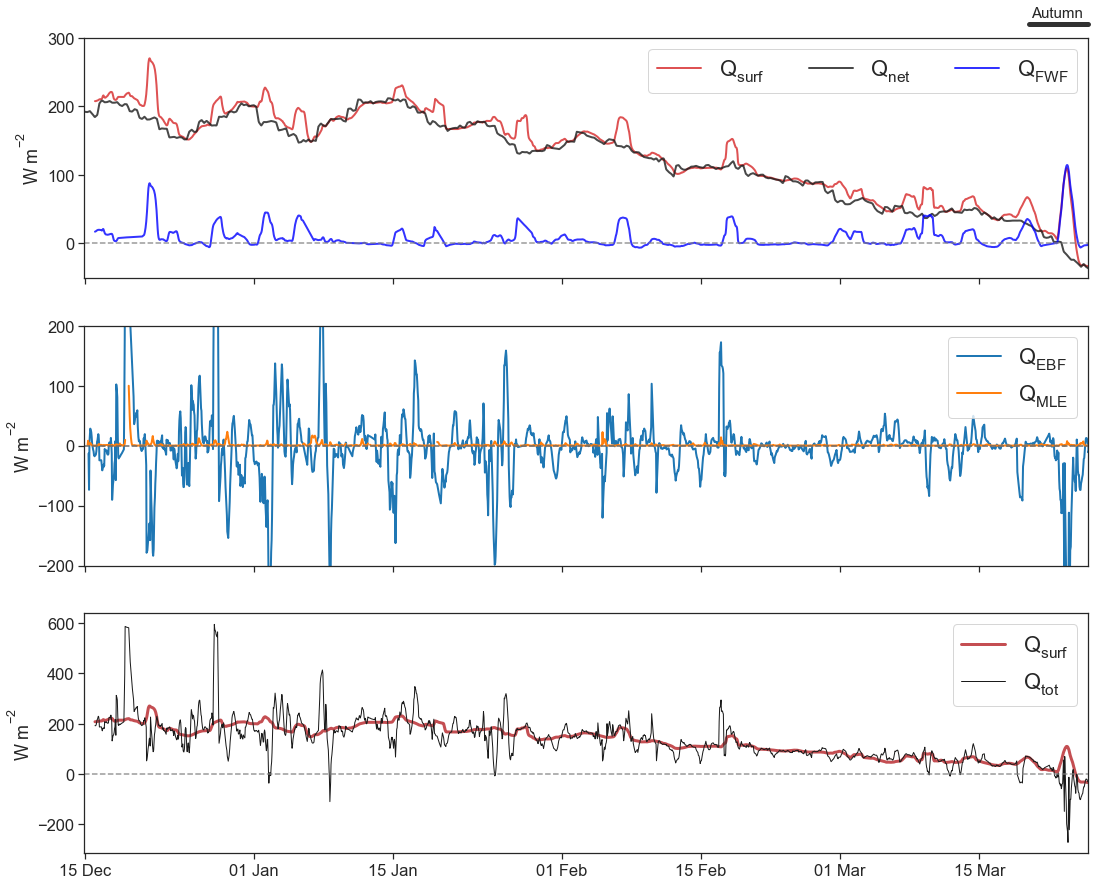

In [434]:
# Plot all
from matplotlib import pyplot, lines

fig,ax=plt.subplots(3,1,figsize=[18,15],sharex=True)
sns.set(font_scale=2)


sns.set_style('white')

sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})


from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.projections import get_projection_class

#heat flux
Qsurf = pd.Series(Qnet_F).interpolate() + pd.Series(Qnet_interp).interpolate()

ax[0].plot(time,pd.Series(Qsurf).rolling(24).mean(),label='Q$_{surf}$',c='tab:red',alpha=0.8,linewidth=2)
ax[0].plot(time,pd.Series(Qnet_interp),label='Q$_{net}$',c='k',alpha=0.8,linewidth=2)#ax[0].plot(time, Qfwf_interp,label='Q$_{latent}$',alpha=0.8,linewidth=3)
ax[0].plot(time,pd.Series(Qnet_F).rolling(24).mean().interpolate(),label='Q$_{FWF}$',alpha=0.8,linewidth=2,c='blue')
#ax[0].plot(era5_annual.time,pd.Series(Qnet_interp),c='k',linewidth=4,label='Q$_{net}$')

ax[0].set_ylabel('W m$^{-2}$')

ax[0].legend(ncol=3)
ax[0].axhline(0,linestyle='--',c='Grey',alpha=0.8)
ax[0].set_ylim(-50,300)

# SMS
ax[1].plot(time.iloc[:-1],pd.Series(ebf).rolling(10).mean().interpolate(),c='tab:blue',linewidth=2,label='Q$_{EBF}$')
ax[1].plot(time.iloc[:-1],Qmle,c='tab:orange',linewidth=2,label='Q$_{MLE}$')


ax[1].axhline(0,c='k',linestyle='--',alpha=0.5)
ax[1].set_ylim(-200,200)
ax[1].set_ylabel('W m$^{-2}$')

Qtot=pd.Series(pd.Series(ebf).rolling(10).mean().interpolate()+Qmle+pd.Series(Qsurf).rolling(24).mean()).interpolate()
ax[1].legend()
ax[1].axhline(0,linestyle='--',c='Grey',alpha=0.8)

# SMS plus atmospheric
ax[2].plot(time,pd.Series(Qsurf).rolling(24).mean(),c='r',linewidth=3,label='Q$_{surf}$')


ax[2].plot(time,Qtot,c='k',linewidth=1,label='Q$_{tot}$')
ax[2].set_xlim(time.iloc[0],time.iloc[-1])
ax[2].legend()
ax[2].set_ylabel('W m$^{-2}$')

ax[2].axhline(0,linestyle='--',c='Grey',alpha=0.8)

a=pd.to_datetime(np.array(time[1954:-1]))
x,y = np.array([[(a[0]), (a[-1])], [320, 320]])
line = lines.Line2D(x, y, lw=5., color='k', alpha=0.9)
ax[0].add_line(line)
line.set_clip_on(False)


ax[0].text(a[5],330,'Autumn',fontsize=15)


h_fmt= mdates.DateFormatter('%d %b')
ax[2].xaxis.set_major_formatter(h_fmt)

plt.savefig('results/sg643_sms_fluxes_all.pdf',bbox_inches='tight',dpi=75)



### bx and ebf underestimation analysis

Assume front is oriented north south such that direction of geostrophic shear is east west.   
For glider to sample the front perpendicularly, the glider should be angled north south to capture the full horizontal gradient(i.e. 0). Assume that bx is computed over 1000m = 1e-7. Use all the acute angles of the glider, we can compute the theoretical observed distance across the front and from this estimate how much the glider is underestimating the lateral gradients. 


In [ ]:
o=1000
theta = np.abs(glider_dir)
theta_allpossibilities = np.linspace(1,90,len(glider_dir))
bactual=1e-4/1000 # if glider is perpendicular to front (equivalent to 0degrees here)
bobs=[]
for i in range(len(theta[:])):
    if theta[i]<90:
        h=o/np.cos(np.deg2rad(theta[i]))
        bobs.append(1e-4/h)
    else:
        theta2 = 180-theta[i]
        h=o/np.cos(np.deg2rad(theta2))
        bobs.append(1e-4/h)

ballposs=[]
for i in range(len(theta_allpossibilities[:])):

        h=o/np.sin(np.deg2rad(theta_allpossibilities[i]))
        ballposs.append(1e-4/h)


In [ ]:
allpossiblewindangles=np.linspace(-180,180,len(glider_dir))
windangle=np.ones(len(glider_dir))*0
perpAngle=np.ones(len(glider_dir))*180
actualwindangles=wind_dir_interp[:-1]
windsorted=(actualwindangles)

txt=np.ones(len(glider_dir))*0.1
tyt=np.ones(len(glider_dir))*0.1

ebf_actual,_=sms_fluxes.calc_ebf(1e-7,np.abs(actualwindangles),np.ones(len(glider_dir))*180,txt,tyt,f,5e-5,cp=4000,g=9.8)

#ebf_actual,_=sms_fluxes.calc_ebf(1e-7,[270,270],[90,90],
 #                         [0.1,0.1],[0.1,0.1],f,5e-5,cp=4000,g=9.8)
ebf_obs,_=sms_fluxes.calc_ebf(1e-7,np.abs(actualwindangles),np.abs((glider_dir)),
                          txt,tyt,f,5e-5,cp=4000,g=9.8)

In [ ]:
import seaborn as sns
sns.distplot(np.ma.masked_invalid((ebf_obs[:]))/ebf_actual)
#plt.xlim(-10,10)

In [ ]:
plt.plot(np.sort(ebf_obs))
plt.plot(np.sort(ebf_actual))

In [ ]:
import sklearn.metrics
import math
mse = sklearn.metrics.mean_squared_error( np.sort(bobs),np.ones(len(bobs))*1e-7)
print(mse)
rmse = math.sqrt(mse)
print(rmse)
print(np.nanmean(rmse/1e-7))

In [ ]:
mse = sklearn.metrics.mean_squared_error((ebf_obs),(ebf_actual))
#rint(mse)
print(rmse)
print(np.sort(ebf_actual))
print(np.sort(ebf_obs))
print(np.nanmean(rmse/np.nanmean(ebf_actual)))
#1-0.43

## Spectra Analysis

This whole section needs to be cleaned up

In [47]:
# find density values in middle of the ML

# point lateral buoyancy gradient in the middle of the ML
rhomd=np.ndarray(len(rho[10,:]))
for i in range(len(rho[10,:])):
    rhomd[i]=rho[np.int8(mld[i]/2),i]
    
rhomd=pd.Series(rhomd).interpolate()

df['rho_md']=rhomd

In [77]:
def plot_slope(xf,yf,N,fmin,fmax):
    """
    Output slope of spectral using defined boundaries
    """
    
    i=np.nonzero((xf>=fmin)&(xf<=fmax)&(xf!=0))[0]
    xf=xf[i]
    yf=yf[i]
    
    
    
   # y=2.0/N * np.abs(yf[0:N//2])
    Y=np.log(yf)
    X=np.log(xf)
    from scipy import stats
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

    #confidence_interval = 2.58*std_err #99%
    confidence_interval = 1.96*std_err #95%


    p=np.polyfit(X,Y,1)

    offy=1

    trend=np.exp(p[0]*X+p[1]+offy)
    xvalue=xf
    return trend,slope,xvalue,confidence_interval

In [78]:
from spectrum import *
from JD_multitaper import JD_spectra  
from scipy.fftpack import fft
from scipy import signal
from JD_multitaper import JD_space_spectra,plot_ref_slope # spectra calculated from code provided by
                                                                        #J. Deshayes, CNRS IRD, March 2013
from scipy import stats

def detrend(h):
    n = len(h)
    t = np.arange(n)
    p = np.polyfit(t, h, 1)
    h_detrended = h - np.polyval(p, t)
    return h_detrended
    
def quadwin(n):
    """
    Quadratic (or "Welch") window
    """
    t = np.arange(n)
    win = 1 - ((t - 0.5 * n) / (0.5 * n)) ** 2
    return win

In [79]:
from scipy.io.matlab import mio
import numpy as np
import spectrum as sp
from scipy import stats


def pmtmPH(x,dt=1.,nw=3,nfft=None):
    """
    function [P,s,ci] = pmtmPH(x,dt,nw,qplot,nfft);
    Computes the power spectrum using the multi-taper method with adaptive weighting.
    Inputs:
    x      - Input data vector.
    dt     - Sampling interval, default is 1.
    nw     - Time bandwidth product, acceptable values are
    0:.5:length(x)/2-1, default is 3.  2*nw-1 dpss tapers
    are applied except if nw=0 a boxcar window is applied 
    and if nw=.5 (or 1) a single dpss taper is applied.
    qplot  - Generate a plot: 1 for yes, else no.  
    nfft   - Number of frequencies to evaluate P at, default is
    length(x) for the two-sided transform. 
    Outputs:
    P      - Power spectrum computed via the multi-taper method.
    s      - Frequency vector.
    ci     - 95% confidence intervals. Note that both the degrees of freedom
    calculated by pmtm.m and chi2conf.m, which pmtm.m calls, are
    incorrect.  Here a quick approximation method is used to
    determine the chi-squared 95% confidence limits for v degrees
    of freedom.  The degrees of freedom are close to but no larger
    than (2*nw-1)*2; if the degrees of freedom are greater than
    roughly 30, the chi-squared distribution is close to Gaussian.
    The vertical ticks at the top of the plot indicate the size of
    the full band-width.  The distance between ticks would remain
    fixed in a linear plot.  For an accurate spectral estimate,
    the true spectra should not vary abruptly on scales less than
    the full-bandwidth.
    Other toolbox functions called: dpps.m; and if nfft does not equal length(x)    , cz.m
    Peter Huybers
    MIT, 2003
    phuybers@mit.edu

    Adapted from Matlab to Python by Nicolas Barrier"""
   # print(len(x))
    if nfft is None:
        nfft=len(x)

    nx=len(x)
    k=np.min([np.round(2*nw),nx])
    k=np.max([k-1,1])
    s=np.arange(0,1/dt,1/(nfft*dt));
    w=nw/(dt*nx) # half-bandwidth of the dpss
    
    E,V=sp.dpss(nx,NW=nw,k=k)
 
    if nx<=nfft:
        tempx=np.transpose(np.tile(x,(k,1)))
        Pk=np.abs(np.fft.fft(E*tempx,n=nfft,axis=0))**2
    else:
        raise IOError('Not implemented yet')
    
    #Iteration to determine adaptive weights:    
    if k>1:
        xmat=np.mat(x).T
        sig2 = xmat.T*xmat/nx; # power
        P    = (Pk[:,0]+Pk[:,1])/2.;   # initial spectrum estimate
        Ptemp= np.zeros(nfft);
        P1   = np.zeros(nfft);
        tol  = .0005*sig2/nfft;    
        a    = sig2*(1-V);
        while np.sum(np.abs(P-P1)/nfft)>tol:
            Pmat=np.mat(P).T
            Vmat=np.mat(V)
            amat=np.mat(a)
            temp1=np.mat(np.ones((1,k)))
            temp2=np.mat(np.ones((nfft,1)))
            b=(Pmat*temp1)/(Pmat*Vmat+temp2*amat); # weights
            temp3=np.mat(np.ones((nfft,1)))*Vmat
            temp3=np.array(temp3)
            b=np.array(b)
            wk=b**2*temp3       
            P1=np.sum(wk*Pk,axis=1)/np.sum(wk,axis=1)
            Ptemp=P1; P1=P; P=Ptemp;                 # swap P and P1

        #b2=b**2
        #temp1=np.mat(np.ones((nfft,1)))*V
        temp1=b**2
        temp2=np.mat(np.ones((nfft,1)))*Vmat
        num=2*np.sum(temp1*np.array(temp2),axis=1)**2
        
        temp1=b**4
        temp2=np.mat(np.ones((nfft,1)))*np.mat(V**2)
        den=np.sum(temp1*np.array(temp2),axis=1)
        v=num/den
        
    select=np.arange(0,(nfft+1)/2+1).astype(np.int64)
    P=P[select]
    s=s[select]
    v=v[select]
  #  print(v.shape)

    temp1=1/(1-2/(9*v)-1.96*np.sqrt(2./(9*v)))**3
    temp2=1/(1-2/(9*v)+1.96*np.sqrt(2/(9*v)))**3

    ci=np.array([temp1,temp2])
    
    return P,s,ci


def plot_ref_slope(fmin,fmax,f,ax,kvec=[2,3],col='Grey',lw=2,ls='--'):

    """ This function draws reference slopes (k=-2, k=-4 for instance)
    Arguments:
    fmin=frequency where to start the reference the slope
    fmax=fmin=frequency where to end the reference the slope
    f= y intercept of the slope
    ax=the axes in which the slopes are plotted
    
    Optional arguments:
    kvec=[2]: list containing the reference values of k, whose slope to draw
    col='k': colors of the slopes
    lw=2: linewidths of the slopes
    ls=--: linestyles of the slopes

    Author: Nicolas Barrier
    """

    x=np.linspace(fmin,fmax,5)
    
    for p in range(0,len(kvec)):
        k=kvec[p]
        y=np.log(f)+k*(np.log(fmin)-np.log(x[:]))
        yout=np.exp(y)
        ax.loglog(x,yout,color=col,linewidth=lw,linestyle=ls)
        ax.text(x[-3],yout[-1],' k = -'+str(k),ha='center',va='center',color=col,fontsize='12')
        #bbox=dict(boxstyle="round", fc="0.9"))



In [80]:
# Separate into transects for some analysis

import pandas as pd

df=pd.DataFrame(data={'lat':lat[:-1],'lon':lon[:-1],
                      'rho10':pd.Series((rho[5,:-1])).interpolate('bfill'),
                      'rho100':pd.Series((rho[150,:-1])).interpolate('bfill'),
                      'rho200':pd.Series((rho[250,:-1])).interpolate('bfill'),
                      'SA':SA[250,:-1]
                     })
#### I hacked this, not very efficient but it works
tr=[]
count=1
for i in range(len(df.lat)):
    
    if (np.diff(df.lat[i:i+2])<0.002)&(np.diff(df.lat[i:i+2])>-0.002)==True:
            tr.append(i)
trd=np.diff(tr)

tr = [120,296,350, 376,410,435,467,488,522,546, 581,608,638,668,700,722,758,782,815,
      843,876,901,940,965,997,1020,1048,1068,1110,1128,1159,1198,1220,1250,1280,
      1361,1508,1568,1596,1623,1658,
      1697,1723,1749,1792,1824,1859,1890,1920,1945,1980,2000,2039,2074]

trd=np.diff(tr)

trans=np.zeros(120)


for i,j in enumerate(trd):
    trans=np.concatenate((trans,(np.ones(j)*i+1)))

df['trans']=np.int8(trans)

<ipython-input-80-e8b6f817e1e8>:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if (np.diff(df.lat[i:i+2])<0.002)&(np.diff(df.lat[i:i+2])>-0.002)==True:


In [81]:
### define colors

blue1=(33/256, 102/256, 172/256)
blue2=(67/256, 147/256, 195/256)
blue3=(146/256, 197/256, 222/256)

red1=(178/256, 24/256, 43/256)
red2=(214/256, 96/256, 77/256)
red3=(244/256, 165/256, 130/256)

-2.41353299923 0.16485253585
-2.67433273521 0.113798274318
-4.08915926384
-3.72942905152
-2.65021638437
-4.52759618267
-2.53871778991
-2.45037417402
-1.99072496473
-2.20401223317
-3.6317457168
-3.72821674006
-3.90009908013
-2.39239625763
-2.53380941916
-3.79767941185
-3.58941669451
-3.18313087424
-2.82106487929
-2.31739985803
-3.65720345374
-1.7849794436
-3.16087691211
-2.44365546709
[ 0.          0.02083333  0.04166667  0.0625      0.08333333  0.10416667
  0.125       0.14583333  0.16666667  0.1875      0.20833333  0.22916667
  0.25        0.27083333  0.29166667  0.3125      0.33333333  0.35416667
  0.375       0.39583333  0.41666667  0.4375      0.45833333  0.47916667
  0.5       ]
-2.55070593352 0.188944306123
-2.93451041714
-3.22470814755
-2.80075970409
-2.94741899327
-2.14677301304
-2.98378860616
-2.90489288213
-2.33178295377
-2.53606756808
-2.62688009236
-1.94549898633
-3.14021778516
-4.7599573319
-2.12536363722
-2.62449575428
-2.64636804734 0.104446318638


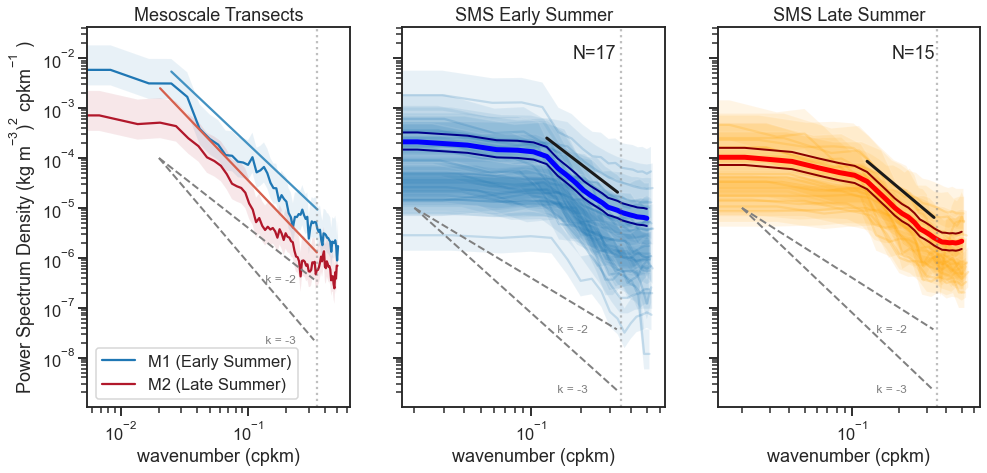

In [92]:
fig,ax=plt.subplots(1,3,figsize=[16,7],sharey=True)
#sns.set_theme()
#sns.set(font_scale=1)

sns.set_style('white')
sns.set_context("talk")

sns.set_style("ticks", {"xtick.major.size": 11, "ytick.major.size": 11})

sns.set_style("ticks", {"xtick.minor.size": 10, "ytick.minor.size": 10})


#########

i=0
h_detrended2 = detrend(df.rho10[df.trans==i]) # detrend
PEm,sEm,ciEm =pmtmPH(h_detrended2,nw=3)

ax[0].loglog(sEm ,PEm,label='M1 (Early Summer)',c='tab:blue',alpha=1)
barmax=ciEm[0,0]*PEm;
barmin=ciEm[1,0]*PEm;
ax[0].fill_between(sEm,barmin,barmax, facecolor='tab:blue', alpha=0.1)

trend,slope,xvalue,conf_interval=plot_slope(sEm,PEm,len(h_detrended2),fmin=0.02,fmax=0.35)
ax[0].loglog(xvalue,trend,color=blue2)

print(slope,conf_interval)

i=36
h_detrended2 = detrend(df.rho10[df.trans==i]) # detrend
PLm,sLm,ciLm =pmtmPH(h_detrended2,nw=3)

ax[0].loglog(sLm ,PLm,label='M2 (Late Summer)',c=red1,alpha=1)
barmax=ciLm[0,0]*PLm;
barmin=ciLm[1,0]*PLm;
ax[0].fill_between(sLm,barmin,barmax, facecolor=red1, alpha=0.1)

trend,slope,xvalue,conf_interval=plot_slope(sLm,PLm,len(h_detrended2),fmin=0.02,fmax=0.35)
ax[0].loglog(xvalue,trend,color=red2)

print(slope,conf_interval)
ax[0].legend()
###################################

ax[0].set_title('Mesoscale Transects')

ax[1].set_title('SMS Early Summer')
ax[2].set_title('SMS Late Summer')

P_all_early=[]
s_all_early=[]
for i in range(3,25,1):
    h_detrended2 = detrend(df.rho10[df.trans==i]) # detrend
    P,s,ci =pmtmPH(h_detrended2,nw=3)
    P_all_early.append(P)
    s_all_early.append(s)
    ax[1].loglog(s,P,label='early',c='tab:blue',alpha=0.2)
    barmax=ci[0,0]*P;
    barmin=ci[1,0]*P;
    ax[1].fill_between(s,barmin,barmax, facecolor='tab:blue', alpha=0.1)
    trend,slope,xvalue,conf_interval=plot_slope(s,P,len(h_detrended2),fmin=0.11,fmax=0.35)
#    ax[0].loglog(xvalue,trend,color='k',label=np.round(slope,2))
#    ax[0].set_xlim(0.07,1)
    print(slope)

P_all_early=np.array(P_all_early,dtype='object')
s_all_early=np.array(s_all_early,dtype='object')   

fs=np.linspace(0,0.5,25)
P_interp_early=[]
for i in range(0,17,1):
    P_interp_early.append(np.interp(fs,s_all_early[i],P_all_early[i]))
P_interp_early=np.array(P_interp_early)
P_mean_early=np.nanmean(P_interp_early,0)
ax[1].loglog(fs,P_mean_early,c='blue',linewidth=5)

from scipy.stats import chi2

probability = 0.95

#P is the number of estimates in welch function
#and also the degree of freedom.
alfa = 1 - probability
v = 2 * len(fs)
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c
Pxxc_lower = P_mean_early * c[0]
Pxxc_upper = P_mean_early * c[1]


ax[1].loglog(fs,Pxxc_lower,c='darkblue',linewidth=2)
ax[1].loglog(fs,Pxxc_upper,c='darkblue',linewidth=2)
print(fs)
#ax[1].set_xlim(0.07,0.6e0)


trend,slope,xvalue,conf_interval=plot_slope(fs,P_mean_early,len(P_mean_early),fmin=0.11,fmax=0.35)
print(slope,conf_interval)
ax[1].loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)    
    
P_all_late=[]
s_all_late=[]
for i in range(37,52,1):

    h_detrended2 = detrend(df.rho10[df.trans==i]) # detrend
    P,s,ci =pmtmPH(h_detrended2,nw=3)
    P_all_late.append(P)
    s_all_late.append(s)
    ax[2].loglog(s,P,label='late',c='orange',alpha=0.2)
    barmax=ci[0,0]*P;
    barmin=ci[1,0]*P;
    ax[2].fill_between(s,barmin,barmax, facecolor='orange', alpha=0.1)

    trend,slope,xvalue,conf_interval=plot_slope(s,P,len(h_detrended2),fmin=0.11,fmax=0.35)
    #plt.loglog(xvalue,trend,color='k',label=np.round(slope,2))
 #   ax[2].set_xlim(0.07,0.6e0)
    print(slope)
P_all_late=np.array(P_all_late,dtype='object')
s_all_late=np.array(s_all_late,dtype='object')

fs=np.linspace(0,0.5,25)
P_interp_late=[]
for i in range(0,15,1):
    P_interp_late.append(np.interp(fs,s_all_late[i],P_all_late[i]))
P_interp_late=np.array(P_interp_late)
P_mean_late=np.nanmean(P_interp_late,0)
ax[2].loglog(fs,P_mean_late,c='red',linewidth=5)

#P is the number of estimates in welch function
#and also the degree of freedom.
alfa = 1 - probability
v = 2 * len(fs)
c = chi2.ppf([1 - alfa / 2, alfa / 2], v)
c = v / c
Pxxc_lower = P_mean_late * c[0]
Pxxc_upper = P_mean_late * c[1]

ax[2].loglog(fs,Pxxc_lower,c='darkred',linewidth=2)
ax[2].loglog(fs,Pxxc_upper,c='darkred',linewidth=2)

trend,slope,xvalue,conf_interval=plot_slope(fs,P_mean_late,len(P_mean_late),fmin=0.11,fmax=0.35)
print(slope,conf_interval)
ax[2].loglog(xvalue,trend,color='k',label=np.round(slope,2),linewidth=3)
    
    
plot_ref_slope(0.02,0.33,1e-5,ax=ax[2])
plot_ref_slope(0.02,0.33,1e-5,ax=ax[1])
plot_ref_slope(0.02,0.33,1e-4,ax=ax[0])

ax[0].set_xlabel('wavenumber (cpkm)')
ax[1].set_xlabel('wavenumber (cpkm)')
ax[2].set_xlabel('wavenumber (cpkm)')

ax[0].set_ylabel('Power Spectrum Density (kg m$^{-3}$)$^2$ cpkm$^{-1}$ )')


ax[1].text(0.18,1e-2,'N=17')
ax[2].text(0.18,1e-2,'N=15')

ax[0].axvline(0.35,c='Grey',linestyle='dotted',alpha=0.5)
ax[1].axvline(0.35,c='Grey',linestyle='dotted',alpha=0.5)
ax[2].axvline(0.35,c='Grey',linestyle='dotted',alpha=0.5)

plt.savefig('results/density_spectra.pdf',bbox_inches='tight',dpi=75)

In [52]:
# Compute distance covered by each transect
transect_distance = []
for i in range(0,54,1):
        tdist=(np.nancumsum(gsw.distance(df2.lon[trans==i],df2.lat[trans==i])))
        tdist=(np.pad(tdist ,(0, 1), mode='constant', constant_values=np.nan))
        transect_distance.append(tdist)
    
transect_distance= np.array(transect_distance).ravel()
#transect_distance = np.hstack(transect_distance)

#df['tdist']=pd.Series(transect_distance)

<ipython-input-52-95daedba90dc>:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  transect_distance= np.array(transect_distance).ravel()


In [53]:
track_distance = np.hstack(transect_distance).squeeze()
df2['track_distance']=track_distance

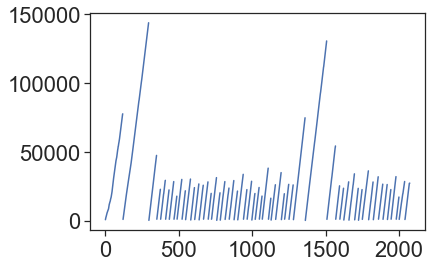

In [54]:
df2.track_distance.plot()
